In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing,SARIMAX,ARIMA
from sklearn.metrics import mean_squared_error

# Rose Dataset

## Read the data as an appropriate Time Series data and plot the data.

In [3]:
rose=pd.read_csv('Rose.csv')
rose.head()

YearMonth   Rose
0   1980-01  112.0
1   1980-02  118.0
2   1980-03  129.0
3   1980-04   99.0
4   1980-05  116.0

In [4]:
dates=pd.date_range(start='1980-01-01',freq='MS',periods=len(rose))

In [5]:
import calendar
rose['month']=dates.month
rose['month']=rose['month'].apply(lambda x: calendar.month_abbr[x])
rose['year']=dates.year
rose.drop(['YearMonth'],axis=1,inplace=True)

In [6]:
rose.set_index(dates,inplace=True)

In [7]:
rose.head()

Rose month  year
1980-01-01  112.0   Jan  1980
1980-02-01  118.0   Feb  1980
1980-03-01  129.0   Mar  1980
1980-04-01   99.0   Apr  1980
1980-05-01  116.0   May  1980

In [8]:
rose.describe()

Rose         year
count  185.000000   187.000000
mean    90.394595  1987.299465
std     39.175344     4.514749
min     28.000000  1980.000000
25%     63.000000  1983.000000
50%     86.000000  1987.000000
75%    112.000000  1991.000000
max    267.000000  1995.000000

In [10]:
rose.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Freq: MS
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rose    185 non-null    float64
 1   month   187 non-null    object 
 2   year    187 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 5.8+ KB


Observations:
- There are two missing values  

In [11]:
rose[rose['Rose'].isna()]

Rose month  year
1994-07-01   NaN   Jul  1994
1994-08-01   NaN   Aug  1994

In [13]:
#imputing with last observed values
rose['Rose'] = rose['Rose'].fillna(method='ffill')

In [15]:
rose.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Freq: MS
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rose    187 non-null    float64
 1   month   187 non-null    object 
 2   year    187 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 5.8+ KB


In [17]:
rose.describe()

Rose         year
count  187.000000   187.000000
mean    89.909091  1987.299465
std     39.244440     4.514749
min     28.000000  1980.000000
25%     62.500000  1983.000000
50%     85.000000  1987.000000
75%    111.000000  1991.000000
max    267.000000  1995.000000

Text(0.5, 1.0, 'Rose Wine Sales')

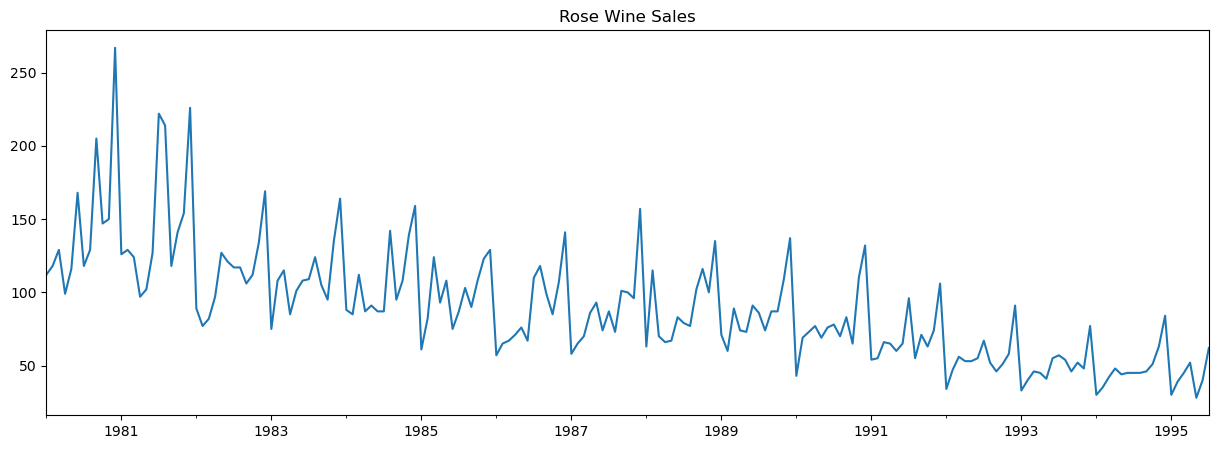

In [16]:
plt.figure(figsize=(15,5))
rose['Rose'].plot()
plt.title('Rose Wine Sales')

Observations:
- The plot represents the Rose wine sales from  Jan 1980 to July 1995, covering a span of 15.5 years- 187 values
- Two values were missing, and the same was imputed with the last observed value
- There seems to be a declining trend and some seasonality associated with this plot. 
- The minimum sales was 28, the maximum sales was 267, with a mean of 89.9

## Perform appropriate Exploratory Data Analysis to understand the data and also perform decomposition.

### EDA

#### Yearly boxplot

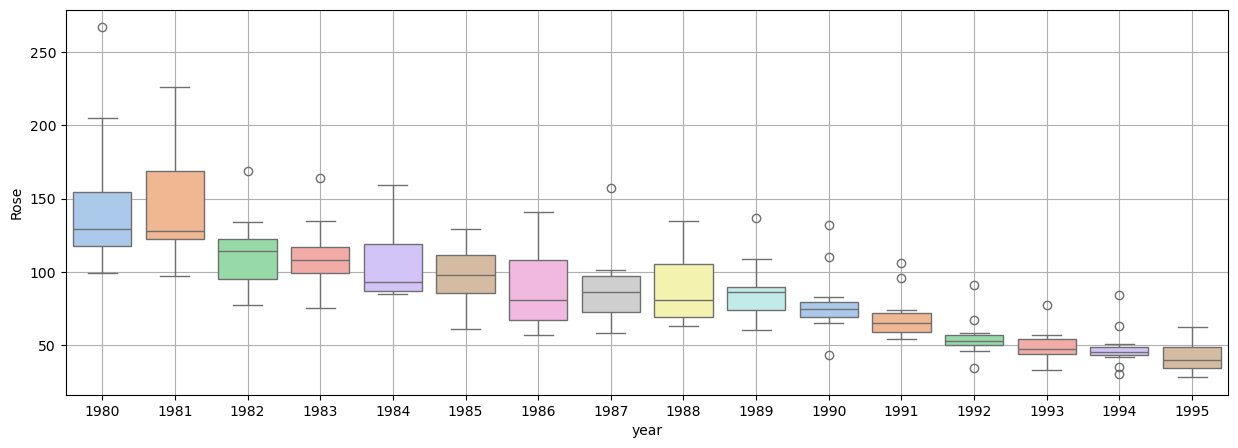

In [18]:
# Trend analysis
plt.figure(figsize=(15,5))
sns.boxplot(x=rose.year,y=rose.Rose,palette='pastel',color='blue')
plt.grid();

Observations:
- Declining trend seen from the above boxplot.

#### Monthly boxplot

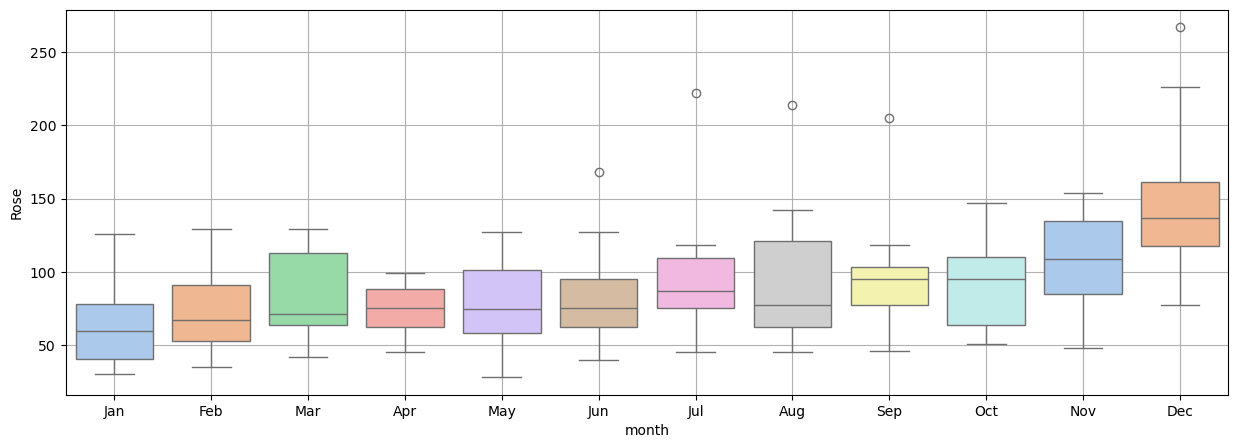

In [19]:
# Seasonality analysis
plt.figure(figsize=(15,5))
sns.boxplot(x=rose.month,y=rose.Rose,palette='pastel',color='blue')
plt.grid();

Observations:
- The sales remains low for the first 9 months and increases slightly in the last 3 months
- Peak sales is in the month of December
- The variability also changes from Jan to Dec. Seasonality is indicated

#### Month-plot

In [20]:
from pylab import rcParams

rcParams['figure.figsize']= 20,8

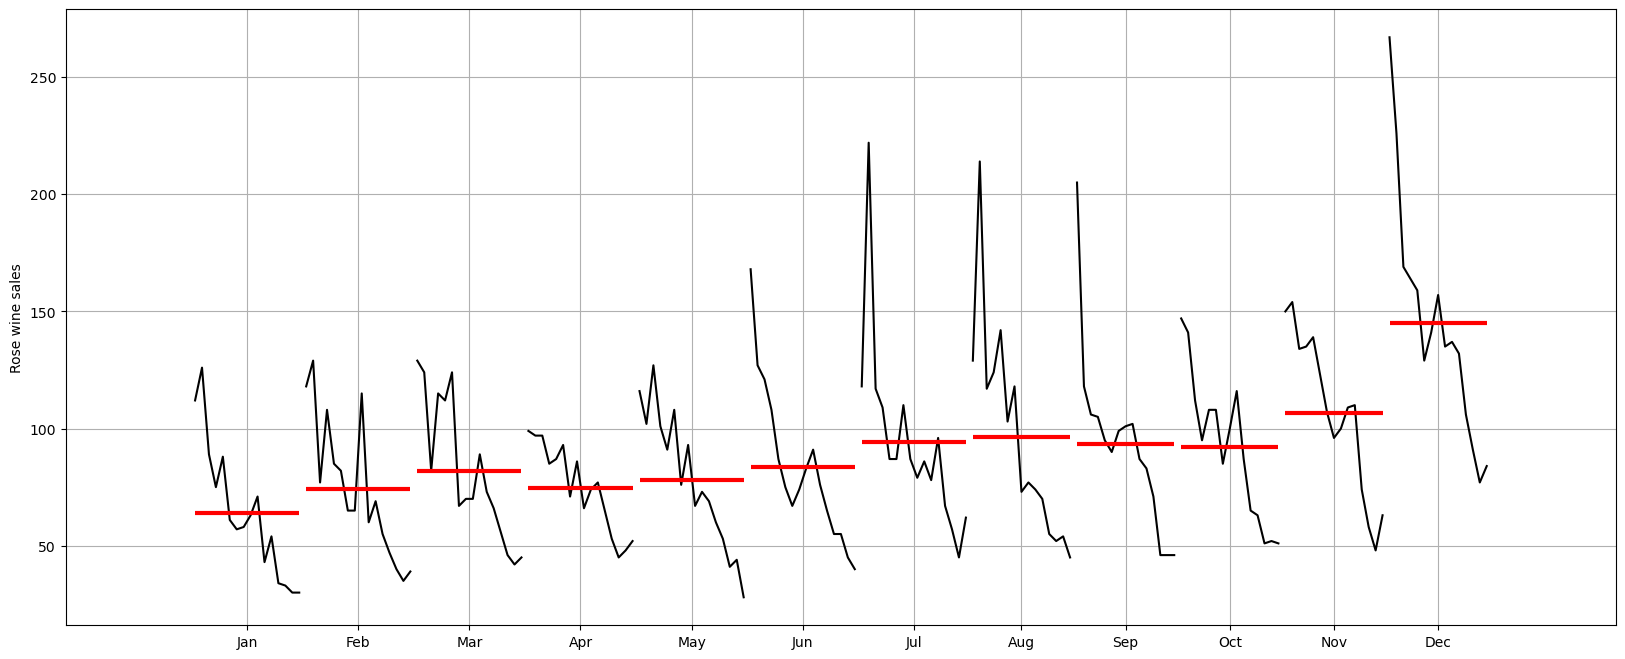

In [21]:
from statsmodels.graphics.tsaplots import month_plot

month_plot(rose['Rose'],ylabel='Rose wine sales')
plt.grid();

Observations:
- The month plots are not very similar to each other

#### Monthly sales movement

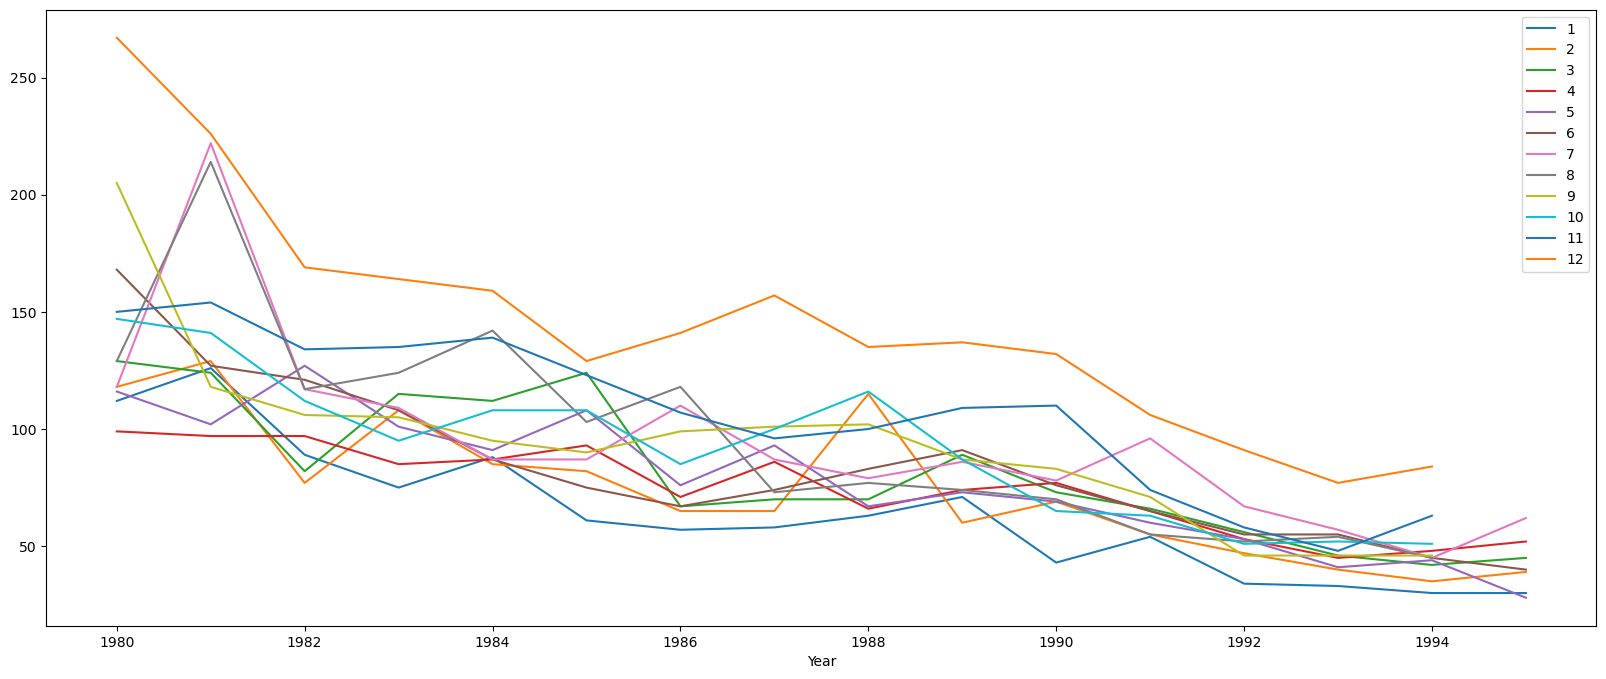

In [22]:
yoy_monthly_sales_movement=pd.pivot_table(rose,values='Rose',columns=rose.index.month,index=rose.year)
yoy_monthly_sales_movement.plot()
plt.xlabel('Year')
plt.legend(loc='best')

Observations:
- For the first 11 months, the lines intersect
- For the month of December, a clear increase in sales is observed

#### Yearly sales movement

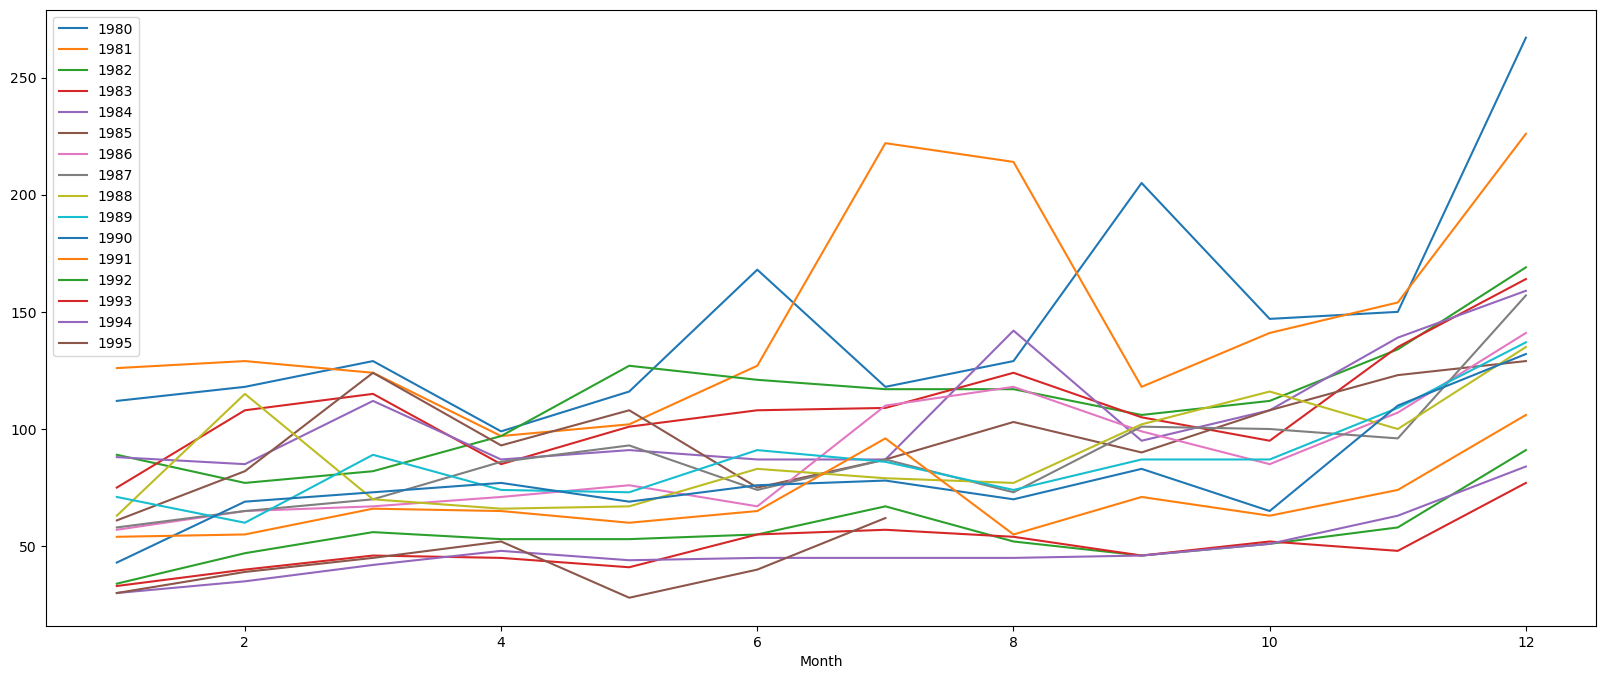

In [23]:
yearly_sales_movement=pd.pivot_table(rose,values='Rose',index=rose.index.month,columns=rose.index.year)
yearly_sales_movement.plot()
plt.xlabel('Month')
plt.legend(loc='best')

Observations:
- Clear decling trend
- Once again, the sales remain flat for the first 9 months of the year, and then rise,peaking in Deccember

### Decomposition

In [24]:
# additive
rose_sales=rose['Rose']
add_decompose=seasonal_decompose(rose_sales,model='additive')

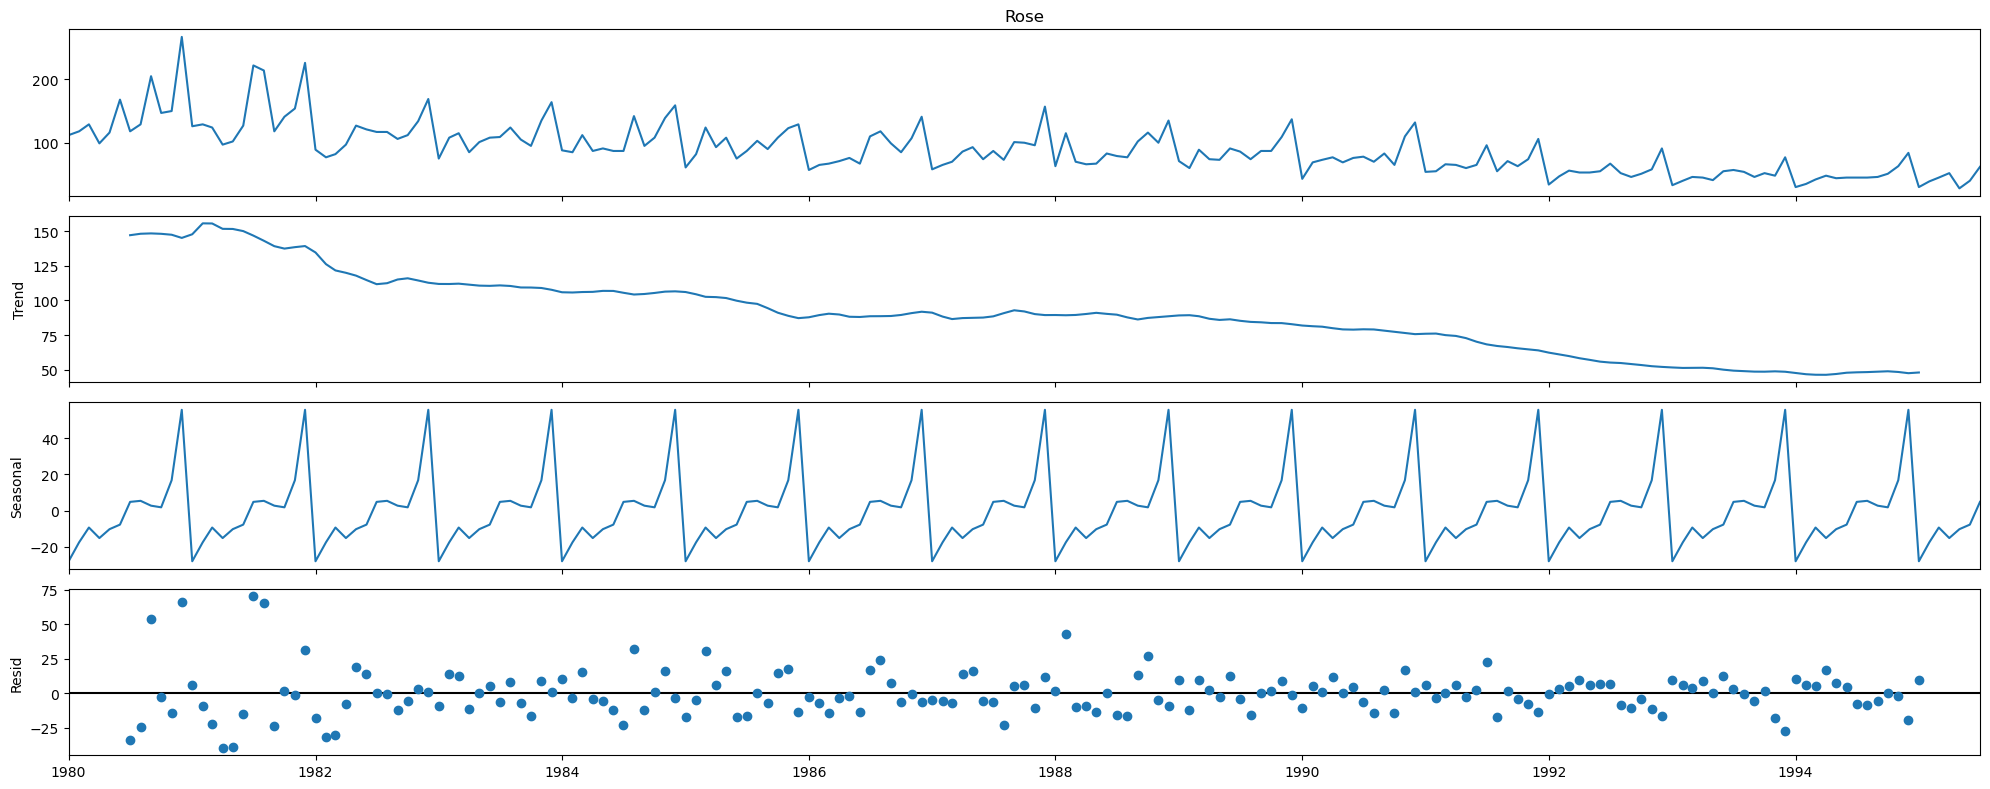

In [25]:
add_decompose.plot();

Observations:
- Clear seasonality component observed
- The residuals are not aligned, and exhibit trend.
- Need to compare with multiplicative seasonality

In [26]:
add_resid=add_decompose.resid

In [27]:
# multiplicative
rose_sales=rose['Rose']
mul_decompose=seasonal_decompose(rose_sales,model='multiplicative')

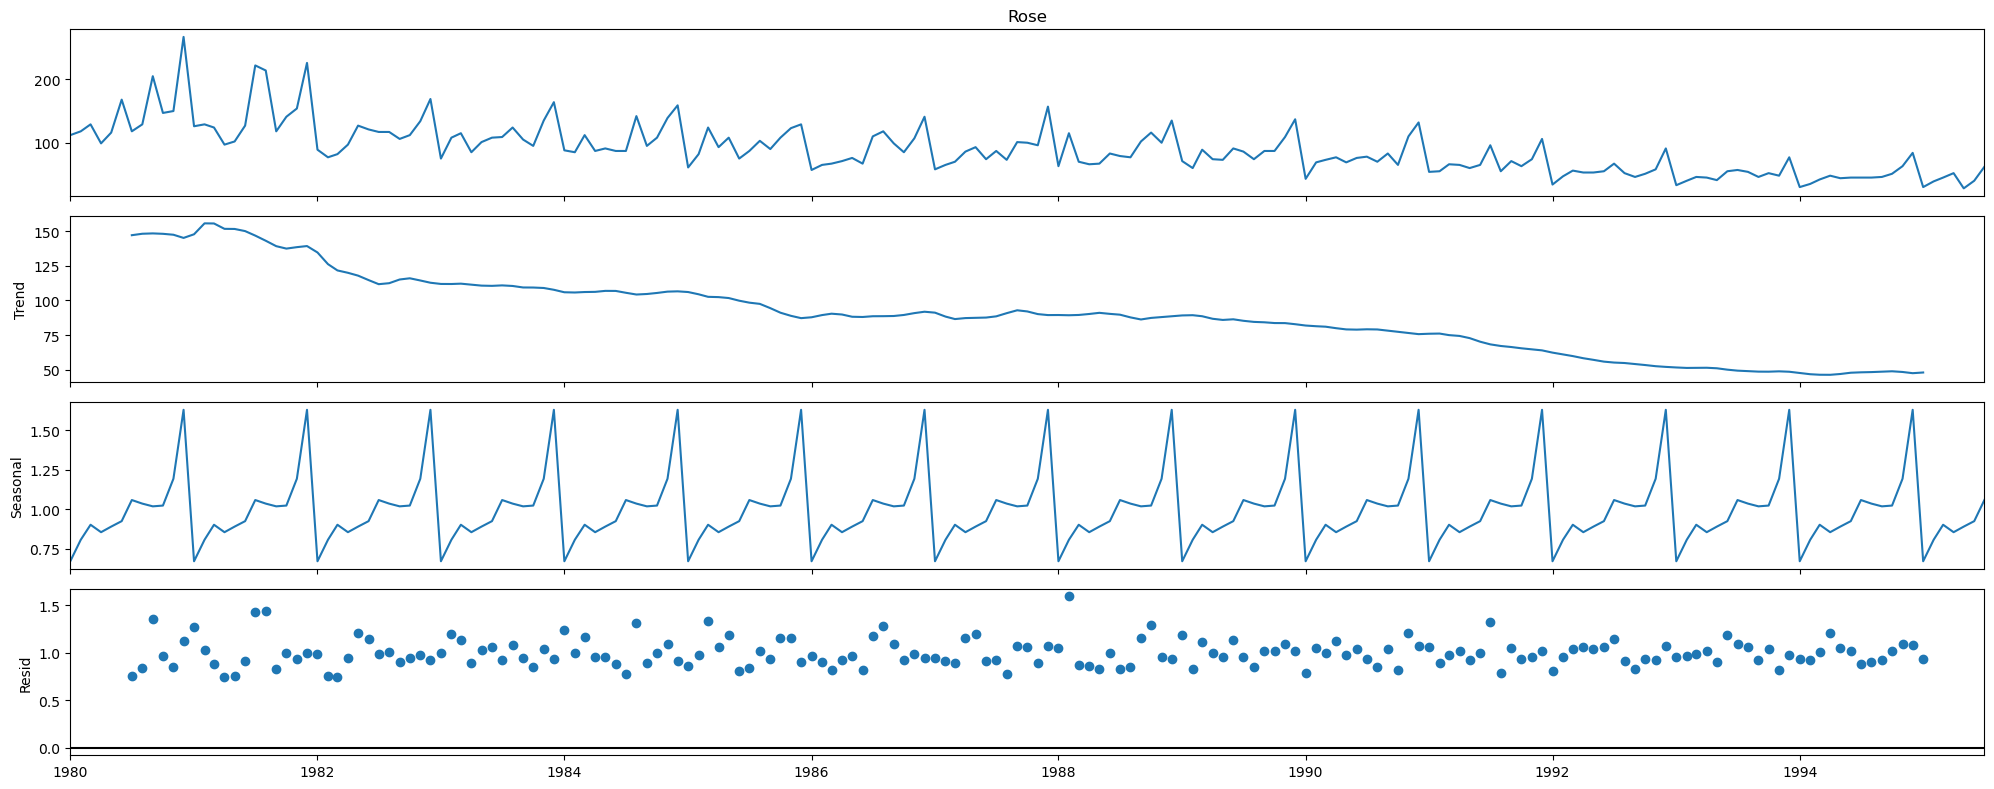

In [28]:
mul_decompose.plot();

In [30]:
resid=mul_decompose.resid
resid_mean=np.mean(resid)
resid_mean

0.9994626392539752

<AxesSubplot:ylabel='Density'>

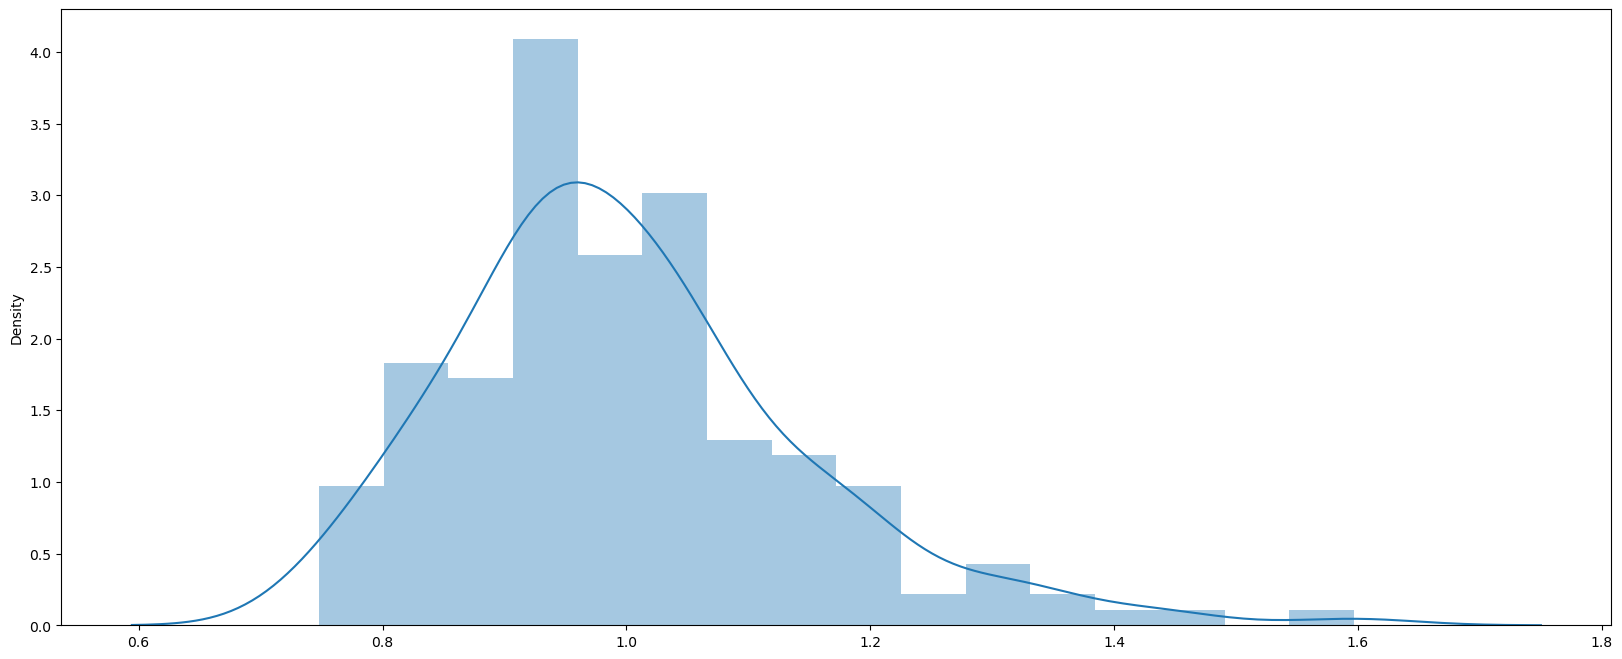

In [33]:
sns.distplot(x=resid)

In [34]:
from scipy.stats import shapiro
statsat, p_val=shapiro(resid)
p_val

1.0

Observations:
- Since the three conditions for multiplicative seasonality are fulfilled, we can assume multiplicative seasonality

In [35]:
trend=mul_decompose.trend
seasonality=mul_decompose.seasonal
resid=mul_decompose.resid

print('\nTrend: ', trend.head(12).round(2))
print('\nSeasonality: ', seasonality.head(12).round(2))
print('\nResiduals: ', resid.head(12).round(2))


Trend:  1980-01-01       NaN
1980-02-01       NaN
1980-03-01       NaN
1980-04-01       NaN
1980-05-01       NaN
1980-06-01       NaN
1980-07-01    147.08
1980-08-01    148.12
1980-09-01    148.38
1980-10-01    148.08
1980-11-01    147.42
1980-12-01    145.12
Freq: MS, Name: trend, dtype: float64

Seasonality:  1980-01-01    0.67
1980-02-01    0.81
1980-03-01    0.90
1980-04-01    0.85
1980-05-01    0.89
1980-06-01    0.92
1980-07-01    1.06
1980-08-01    1.04
1980-09-01    1.02
1980-10-01    1.02
1980-11-01    1.19
1980-12-01    1.63
Freq: MS, Name: seasonal, dtype: float64

Residuals:  1980-01-01     NaN
1980-02-01     NaN
1980-03-01     NaN
1980-04-01     NaN
1980-05-01     NaN
1980-06-01     NaN
1980-07-01    0.76
1980-08-01    0.84
1980-09-01    1.36
1980-10-01    0.97
1980-11-01    0.85
1980-12-01    1.13
Freq: MS, Name: resid, dtype: float64


## Split the data into training and test. The test data should start in 1991.

In [43]:
rose_df=rose.copy()
##rose_df1=rose_df.drop(['month','year'],axis=1,inplace=True)

In [44]:
rose

Rose month  year
1980-01-01  112.0   Jan  1980
1980-02-01  118.0   Feb  1980
1980-03-01  129.0   Mar  1980
1980-04-01   99.0   Apr  1980
1980-05-01  116.0   May  1980
...           ...   ...   ...
1995-03-01   45.0   Mar  1995
1995-04-01   52.0   Apr  1995
1995-05-01   28.0   May  1995
1995-06-01   40.0   Jun  1995
1995-07-01   62.0   Jul  1995

[187 rows x 3 columns]

In [45]:
rose_df.drop(['month','year'],axis=1,inplace=True)

In [46]:
rose_df

Rose
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0
...           ...
1995-03-01   45.0
1995-04-01   52.0
1995-05-01   28.0
1995-06-01   40.0
1995-07-01   62.0

[187 rows x 1 columns]

In [47]:
train=rose_df[rose_df.index.year< 1991]
test=rose_df[rose_df.index.year>= 1991]

In [48]:
train.shape

(132, 1)

In [49]:
test.shape

(55, 1)

In [50]:
train.head()

Rose
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0

In [51]:
train.tail()

Rose
1990-08-01   70.0
1990-09-01   83.0
1990-10-01   65.0
1990-11-01  110.0
1990-12-01  132.0

In [52]:
test.head()

Rose
1991-01-01  54.0
1991-02-01  55.0
1991-03-01  66.0
1991-04-01  65.0
1991-05-01  60.0

In [53]:
test.tail()

Rose
1995-03-01  45.0
1995-04-01  52.0
1995-05-01  28.0
1995-06-01  40.0
1995-07-01  62.0

## Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment.
Note: Stationarity should be checked at alpha = 0.05.

In [36]:
from statsmodels.tsa.stattools import adfuller

In [37]:
## Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean() #determining the rolling mean
    rolstd = timeseries.rolling(window=12).std()   #determining the rolling standard deviation

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

The stationarity of the data can be ascertained by the Dickey-Fuller test. The Null and alternate hypothesis are as follows:
- H0: The series is non-stationary
- Ha: The series is stationary

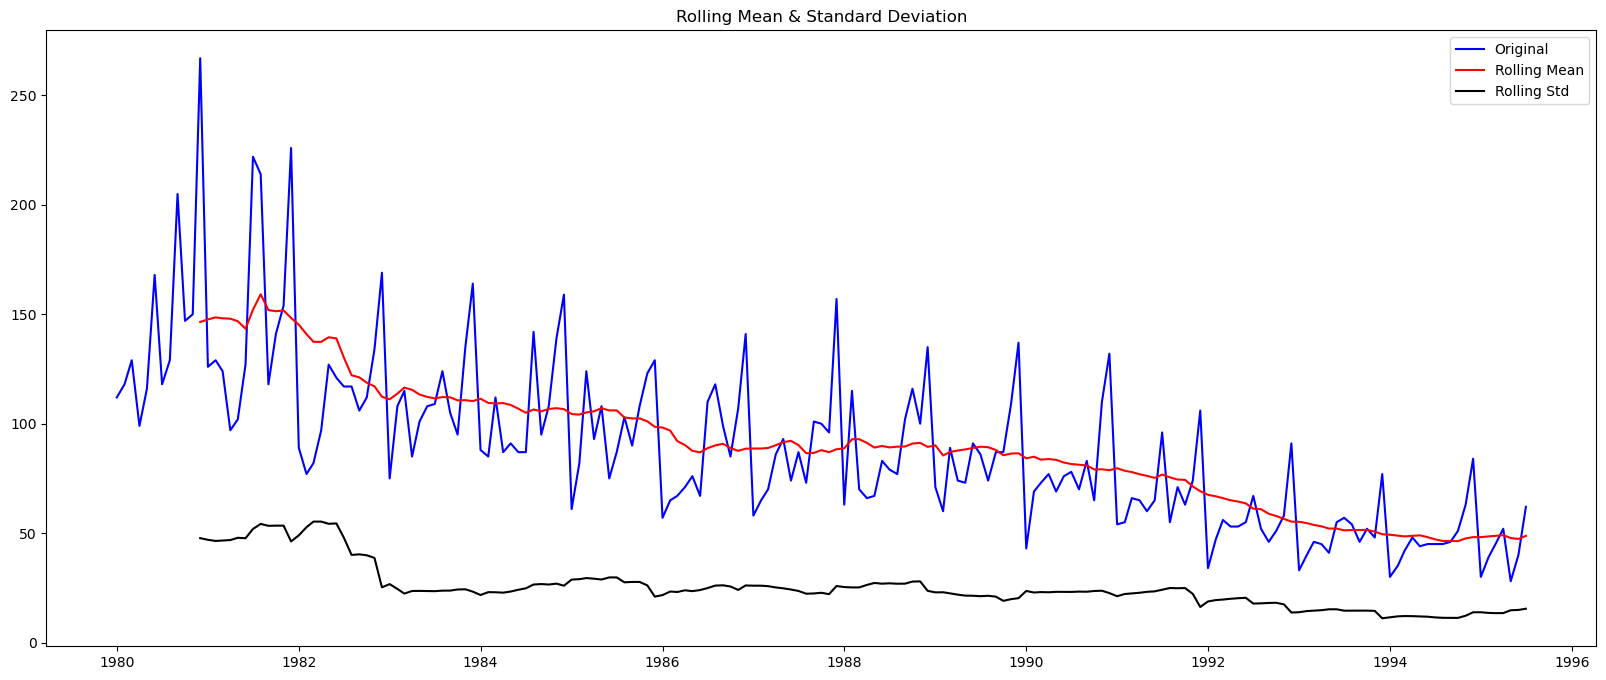

Results of Dickey-Fuller Test:
Test Statistic                  -1.874856
p-value                          0.343981
#Lags Used                      13.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
Critical Value (10%)            -2.575756
dtype: float64 



In [38]:
test_stationarity(rose_sales)

Observations:
- Since the p value is greater than alpha(0.05), we fail to reject the null hypothesis. Hence it is established that the series is not stationary.

In [39]:
diff_series=rose_sales.diff(periods=1).dropna()
res=adfuller(diff_series)
p_val=res[1]
lags=res[2]

Stationarity of original data


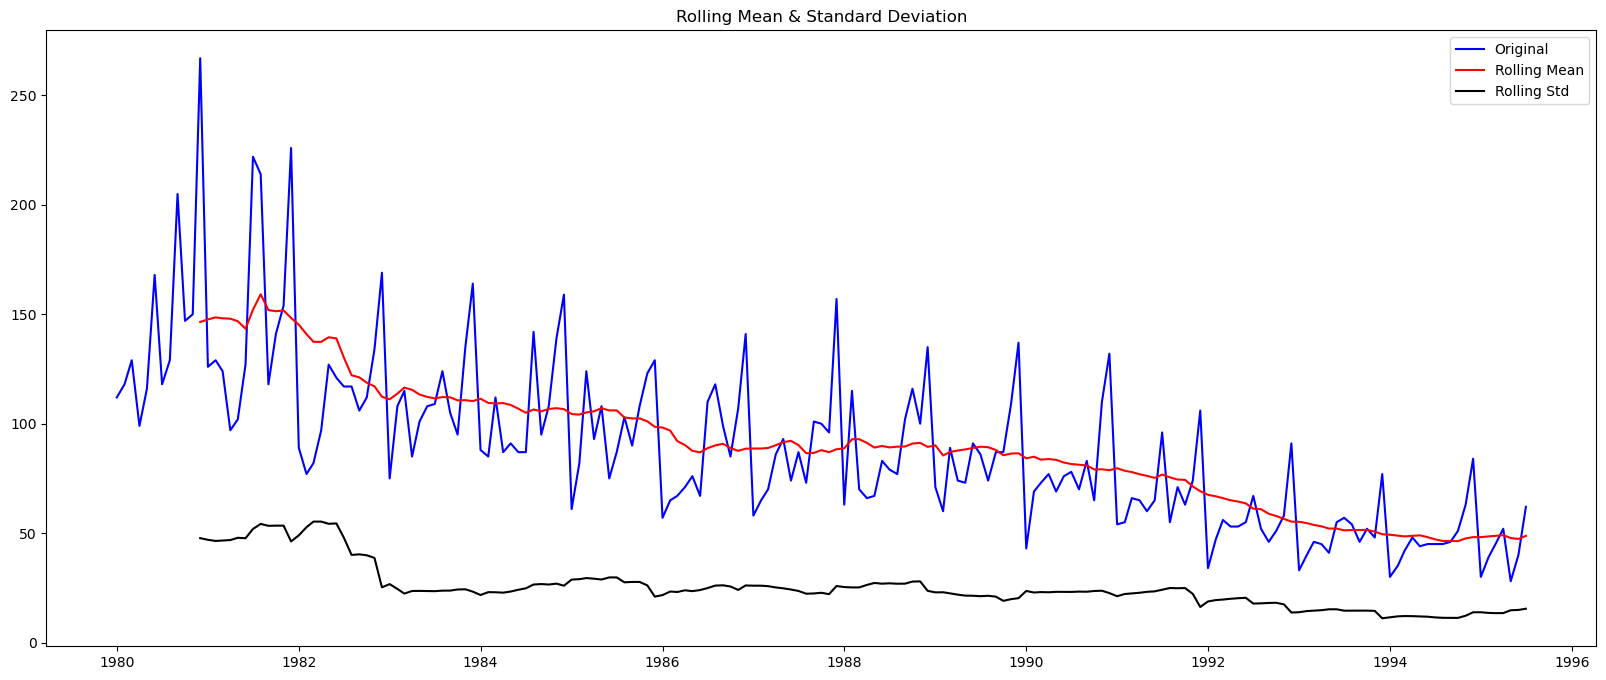

Results of Dickey-Fuller Test:
Test Statistic                  -1.874856
p-value                          0.343981
#Lags Used                      13.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
Critical Value (10%)            -2.575756
dtype: float64 


 Stationarity after first order differencing


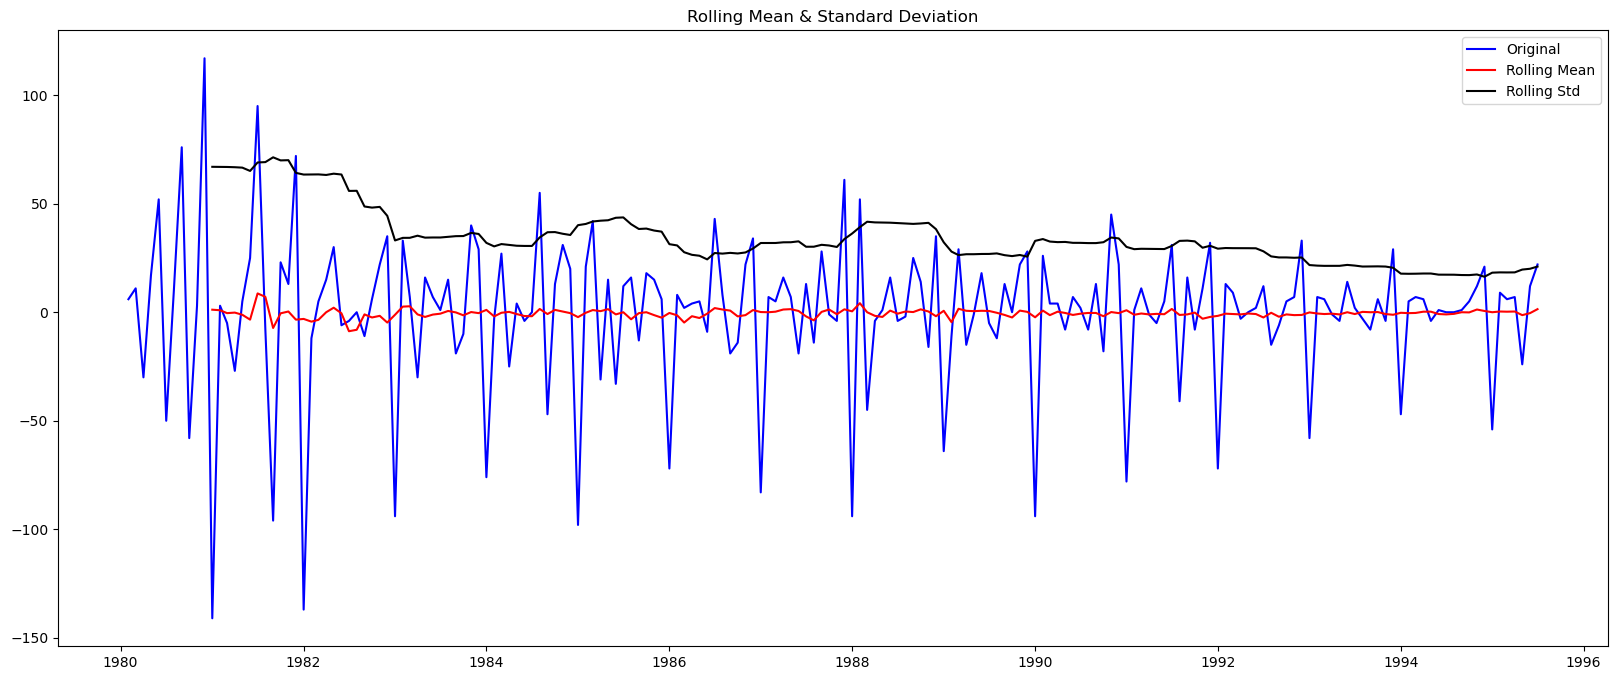

Results of Dickey-Fuller Test:
Test Statistic                -8.044139e+00
p-value                        1.813580e-12
#Lags Used                     1.200000e+01
Number of Observations Used    1.730000e+02
Critical Value (1%)           -3.468726e+00
Critical Value (5%)           -2.878396e+00
Critical Value (10%)          -2.575756e+00
dtype: float64 



In [40]:
print('Stationarity of original data')
test_stationarity(rose_sales)
print('\n Stationarity after first order differencing')
test_stationarity(diff_series)

Observations:
- The given series was originally non- stationary, as evidenced by the Dickey Fuller test, with resulted in a p-value of 0.3
- After performing a first order differencing, stationarity was established. The Dickey fuller test on the differenced series resulted in a p-value of 0.0, which is less than the critical value of 0.05.

## Build all the exponential smoothing models on the training data and evaluate the model using RMSE on the test data. Other additional models such as regression, naïve forecast models, simple average models, moving average models should also be built on the training data and check the performance on the test data using RMSE.

### Simple Models

#### Linear Regression

In [54]:
train_time=[i+1 for i in range(len(train))]
test_time=[i+133 for i in range(len(test))]
print(train_time)
print(test_time)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
[133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]


In [55]:
lr_train_df=train.copy()
lr_test_df=test.copy()
lr_train_df

Rose
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0
...           ...
1990-08-01   70.0
1990-09-01   83.0
1990-10-01   65.0
1990-11-01  110.0
1990-12-01  132.0

[132 rows x 1 columns]

In [56]:
lr_train_df['Time']=train_time
lr_test_df['Time']=test_time

In [57]:
lr_model=LinearRegression()
lr_model.fit(lr_train_df[['Time']],lr_train_df['Rose'].values)

LinearRegression()

In [58]:
lr_model_predict=lr_model.predict(lr_test_df[['Time']])

lr_test_df['predictions']=lr_model_predict

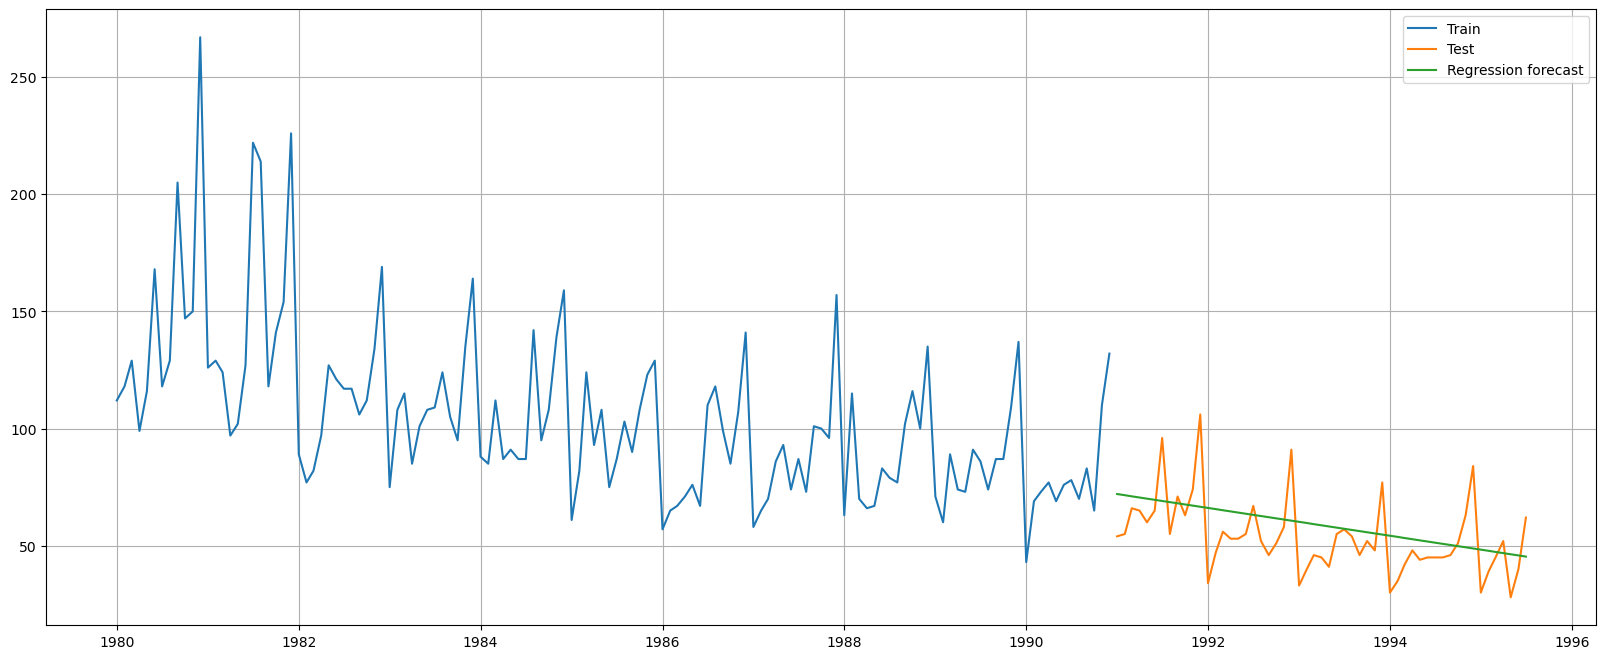

In [59]:
plt.plot(lr_train_df['Rose'],label='Train')
plt.plot(lr_test_df['Rose'],label='Test')
plt.plot(lr_test_df['predictions'],label='Regression forecast')
plt.legend(loc='best')
plt.grid();

In [60]:
rmse_lr=np.sqrt(mean_squared_error(lr_test_df['Rose'],lr_test_df['predictions'])).round(2)
rmse_lr

15.28

In [61]:
results_df=pd.DataFrame({'Test RMSE': rmse_lr},index =['LinearRegression'])
results_df

Test RMSE
LinearRegression      15.28

#### Naive Forecast

In [62]:
naive_train=train.copy()
naive_test=test.copy()

In [63]:
naive_test['predictions']=np.asarray(naive_train['Rose'])[len(np.asarray(naive_train['Rose']))-1]

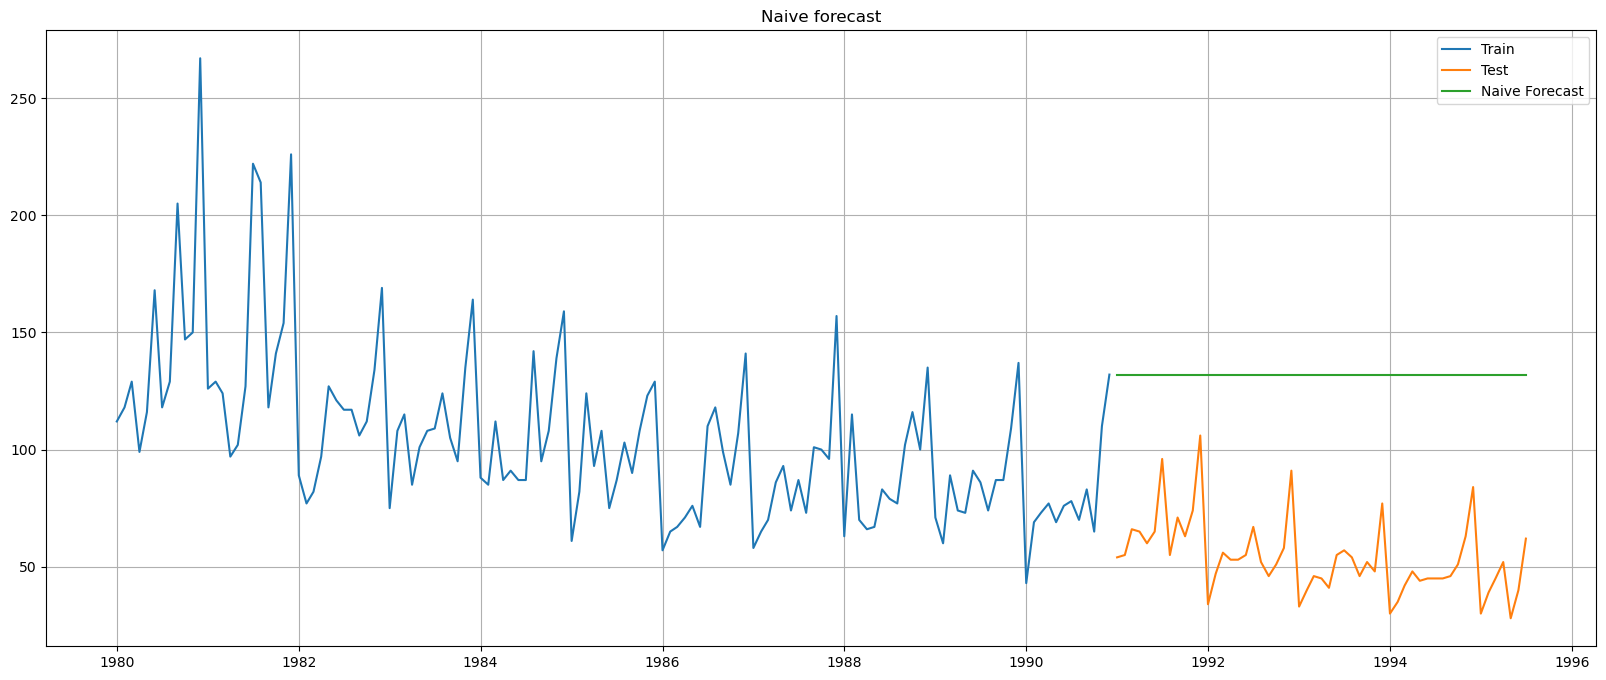

In [64]:
plt.plot(naive_train['Rose'],label='Train')
plt.plot(naive_test['Rose'],label='Test')
plt.plot(naive_test['predictions'],label='Naive Forecast')
plt.legend(loc='best')
plt.title('Naive forecast')
plt.grid();

In [65]:
rmse_naive=np.sqrt(mean_squared_error(naive_test['Rose'],naive_test['predictions'])).round(2)
rmse_naive

79.74

In [66]:
naive_df=pd.DataFrame({'Test RMSE': rmse_naive},index=['NaiveForecast'])
results_df=pd.concat([results_df,naive_df])
results_df

Test RMSE
LinearRegression      15.28
NaiveForecast         79.74

#### Simple average Model

In [67]:
sa_train=train.copy()
sa_test=test.copy()

In [68]:
sa_test['predictions']=sa_train['Rose'].mean()

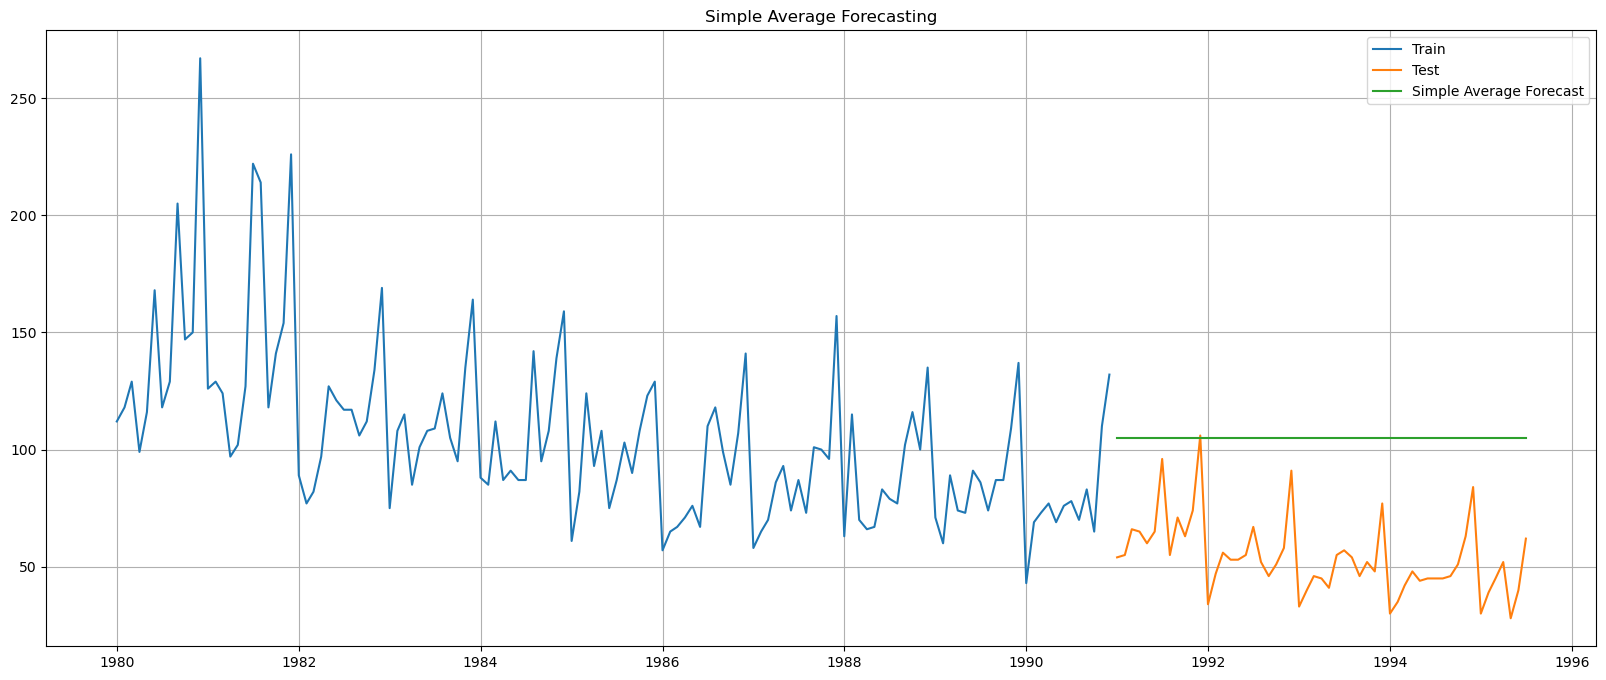

In [69]:
plt.plot(sa_train['Rose'],label='Train')
plt.plot(sa_test['Rose'],label='Test')
plt.plot(sa_test['predictions'],label='Simple Average Forecast')
plt.title('Simple Average Forecasting')
plt.legend(loc='best')
plt.grid();

In [70]:
rmse_sa=np.sqrt(mean_squared_error(sa_test['Rose'],sa_test['predictions'])).round(2)
rmse_sa

53.48

In [71]:
sa_df=pd.DataFrame({'Test RMSE': rmse_sa},index=['SimpleAvgForecast'])
results_df=pd.concat([results_df,sa_df])
results_df

Test RMSE
LinearRegression       15.28
NaiveForecast          79.74
SimpleAvgForecast      53.48

#### Moving average model

In [72]:
ma_df=rose_df.copy()

In [73]:
ma_df['trail2']=ma_df['Rose'].rolling(2).mean().round(2)
ma_df['trail3']=ma_df['Rose'].rolling(3).mean().round(2)
ma_df['trail6']=ma_df['Rose'].rolling(6).mean().round(2)
ma_df['trail12']=ma_df['Rose'].rolling(12).mean().round(2)

In [74]:
ma_train=ma_df[ma_df.index.year<1991]
ma_test=ma_df[ma_df.index.year>=1991]

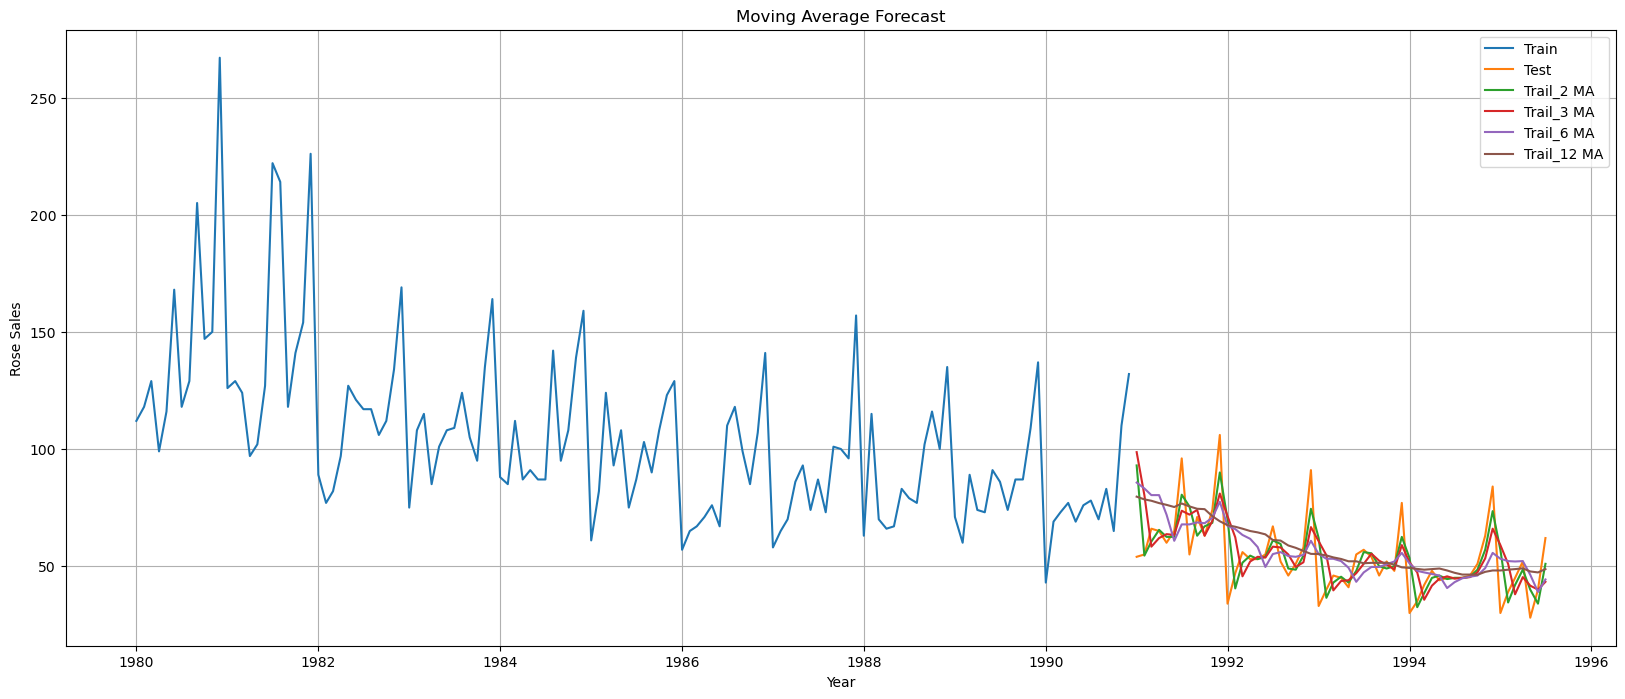

In [75]:
plt.plot(ma_train['Rose'],label='Train')
plt.plot(ma_test['Rose'],label='Test')
plt.plot(ma_test['trail2'],label='Trail_2 MA')
plt.plot(ma_test['trail3'],label='Trail_3 MA')
plt.plot(ma_test['trail6'],label='Trail_6 MA')
plt.plot(ma_test['trail12'],label='Trail_12 MA')
plt.xlabel('Year')
plt.ylabel('Rose Sales')
plt.title('Moving Average Forecast')
plt.legend(loc='best')
plt.grid();

In [76]:
rmse_ma_trail2=np.sqrt(mean_squared_error(ma_test['Rose'],ma_test['trail2'])).round(2)
rmse_ma_trail3=np.sqrt(mean_squared_error(ma_test['Rose'],ma_test['trail3'])).round(2)
rmse_ma_trail6=np.sqrt(mean_squared_error(ma_test['Rose'],ma_test['trail6'])).round(2)
rmse_ma_trail12=np.sqrt(mean_squared_error(ma_test['Rose'],ma_test['trail12'])).round(2)

In [77]:
ma_res_df=pd.DataFrame({'Test RMSE':[rmse_ma_trail2,rmse_ma_trail3,rmse_ma_trail6,rmse_ma_trail12]},index=['MA_trail2','MA_trail3','MA_trail6','MA_trail12'])
ma_res_df

Test RMSE
MA_trail2       11.53
MA_trail3       14.13
MA_trail6       14.57
MA_trail12      15.24

In [78]:
results_df=pd.concat([results_df,ma_res_df])
results_df

Test RMSE
LinearRegression       15.28
NaiveForecast          79.74
SimpleAvgForecast      53.48
MA_trail2              11.53
MA_trail3              14.13
MA_trail6              14.57
MA_trail12             15.24

### Exponential smoothing models

#### Simple Exponential smoothing model

In [79]:
ses_train=train.copy()
ses_test=test.copy()

In [80]:
ses_model=SimpleExpSmoothing(ses_train['Rose']).fit(optimized=True)

In [81]:
ses_model.params

{'smoothing_level': 0.12362013444181875,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [82]:
ses_test['predictions']=ses_model.forecast(steps=len(ses_test))
ses_test

Rose  predictions
1991-01-01   54.0    87.983765
1991-02-01   55.0    87.983765
1991-03-01   66.0    87.983765
1991-04-01   65.0    87.983765
1991-05-01   60.0    87.983765
1991-06-01   65.0    87.983765
1991-07-01   96.0    87.983765
1991-08-01   55.0    87.983765
1991-09-01   71.0    87.983765
1991-10-01   63.0    87.983765
1991-11-01   74.0    87.983765
1991-12-01  106.0    87.983765
1992-01-01   34.0    87.983765
1992-02-01   47.0    87.983765
1992-03-01   56.0    87.983765
1992-04-01   53.0    87.983765
1992-05-01   53.0    87.983765
1992-06-01   55.0    87.983765
1992-07-01   67.0    87.983765
1992-08-01   52.0    87.983765
1992-09-01   46.0    87.983765
1992-10-01   51.0    87.983765
1992-11-01   58.0    87.983765
1992-12-01   91.0    87.983765
1993-01-01   33.0    87.983765
1993-02-01   40.0    87.983765
1993-03-01   46.0    87.983765
1993-04-01   45.0    87.983765
1993-05-01   41.0    87.983765
1993-06-01   55.0    87.983765
1993-07-01   57.0    87.983765
1993-08-01   54.0    87.983765
1993-09-01   46.0    87.983765
1993-10-01   52.0    87.983765
1993-11-01   48.0    87.983765
1993-12-01   77.0    87.983765
1994-01-01   30.0    87.983765
1994-02-01   35.0    87.983765
1994-03-01   42.0    87.983765
1994-04-01   48.0    87.983765
1994-05-01   44.0    87.983765
1994-06-01   45.0    87.983765
1994-07-01   45.0    87.983765
1994-08-01   45.0    87.983765
1994-09-01   46.0    87.983765
1994-10-01   51.0    87.983765
1994-11-01   63.0    87.983765
1994-12-01   84.0    87.983765
1995-01-01   30.0    87.983765
1995-02-01   39.0    87.983765
1995-03-01   45.0    87.983765
1995-04-01   52.0    87.983765
1995-05-01   28.0    87.983765
1995-06-01   40.0    87.983765
1995-07-01   62.0    87.983765

In [83]:
rmse_ses=np.sqrt(mean_squared_error(ses_test['Rose'],ses_test['predictions'])).round(2)
rmse_ses

37.61

In [84]:
ses_df=pd.DataFrame({'Test RMSE': rmse_ses},index=['SimpleExpSmoothing'])
ses_df

Test RMSE
SimpleExpSmoothing      37.61

In [85]:
results_df=pd.concat([results_df,ses_df])
results_df

Test RMSE
LinearRegression        15.28
NaiveForecast           79.74
SimpleAvgForecast       53.48
MA_trail2               11.53
MA_trail3               14.13
MA_trail6               14.57
MA_trail12              15.24
SimpleExpSmoothing      37.61

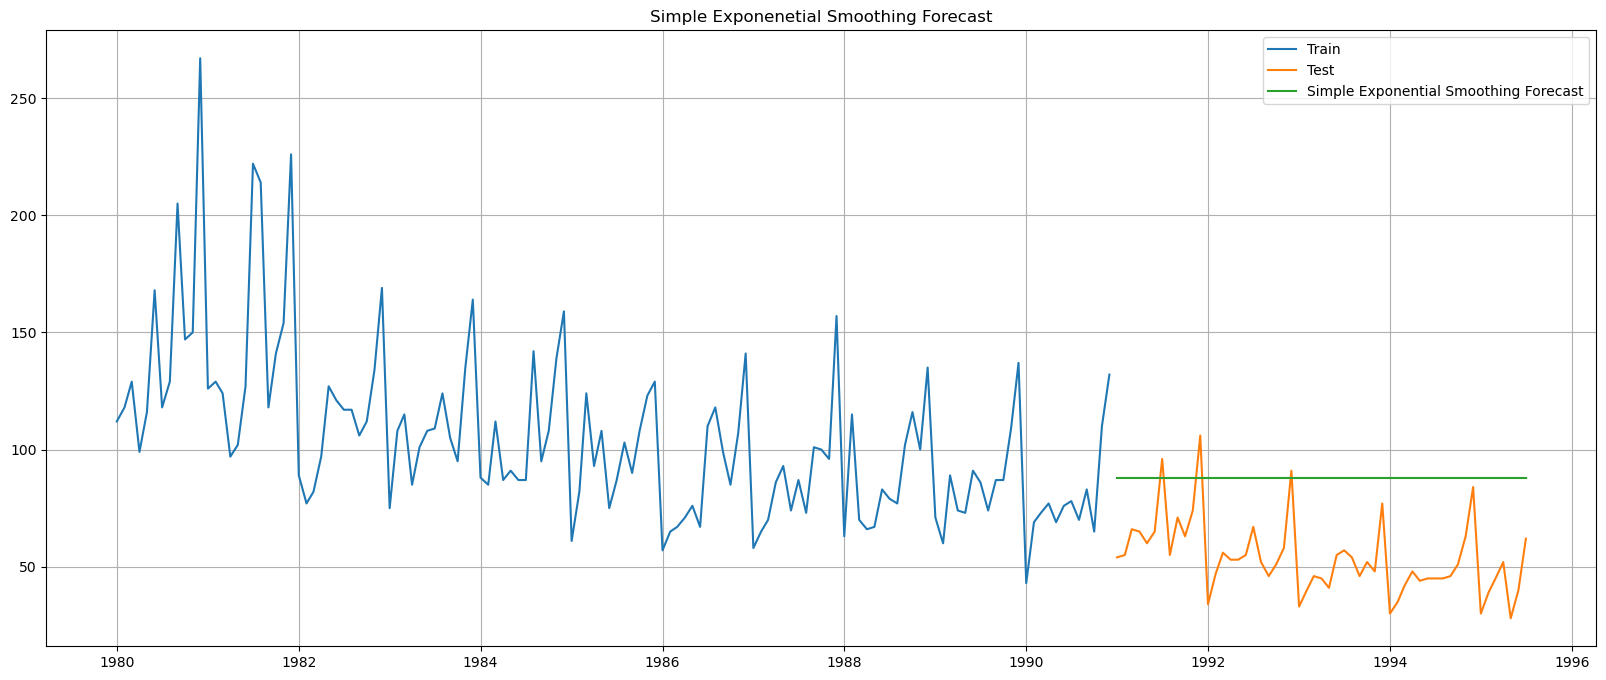

In [86]:
plt.plot(ses_train['Rose'],label='Train')
plt.plot(ses_test['Rose'],label='Test')
plt.plot(ses_test['predictions'],label='Simple Exponential Smoothing Forecast')
plt.title('Simple Exponenetial Smoothing Forecast')
plt.legend(loc='best')
plt.grid();

In [87]:
ses_alpha_df=pd.DataFrame({'Alpha':[],'Rmse_test':[]})

In [88]:
for i in np.arange(0.1,1,0.1):
    ses_alpha=SimpleExpSmoothing(ses_train['Rose']).fit(smoothing_level=i,optimized=False)
    ses_test['predict',i]=ses_alpha.forecast(steps=len(test))
    rmse_alpha=np.sqrt(mean_squared_error(ses_test['Rose'],ses_test['predict',i]))
    ses_alpha_df=ses_alpha_df.append({'Alpha':i,'Rmse_test':rmse_alpha},ignore_index=True)

In [89]:
ses_alpha_df

Alpha  Rmse_test
0    0.1  36.848694
1    0.2  41.382452
2    0.3  47.525251
3    0.4  53.787686
4    0.5  59.661932
5    0.6  64.991324
6    0.7  69.718108
7    0.8  73.793865
8    0.9  77.159094

In [91]:
ses_alpha_model=SimpleExpSmoothing(ses_train['Rose']).fit(smoothing_level=0.1,optimized=False)

In [92]:
ses_test['alpha_predict']=ses_alpha_model.forecast(steps=len(ses_test))

In [93]:
rmse_ses_alpha_model=np.sqrt(mean_squared_error(ses_test['Rose'],ses_test['alpha_predict'])).round(2)
rmse_ses_alpha_model

36.85

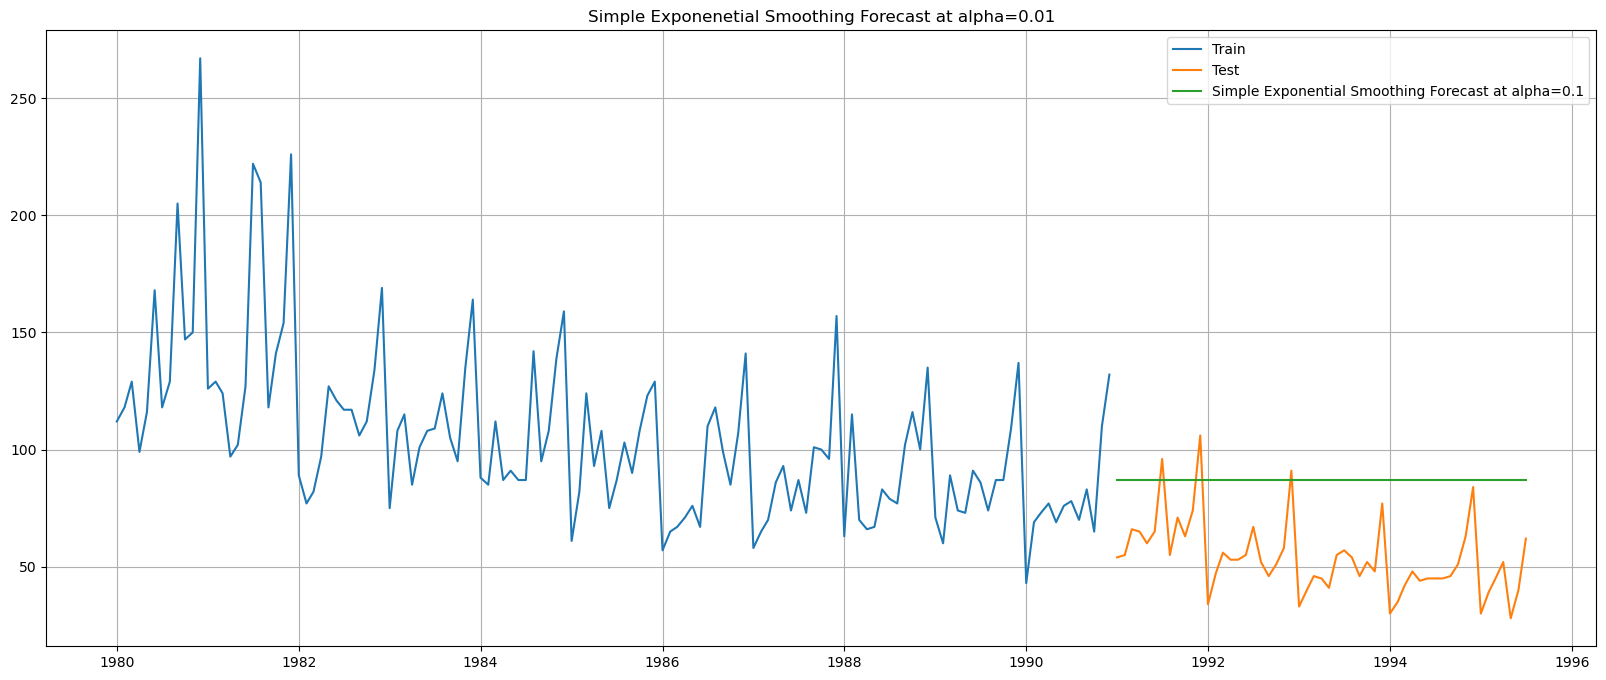

In [94]:
plt.plot(ses_train['Rose'],label='Train')
plt.plot(ses_test['Rose'],label='Test')
plt.plot(ses_test['alpha_predict'],label='Simple Exponential Smoothing Forecast at alpha=0.1')
plt.title('Simple Exponenetial Smoothing Forecast at alpha=0.01')
plt.legend(loc='best')
plt.grid();

In [95]:
ses_alpha_model_results_df=pd.DataFrame({'Test RMSE':rmse_ses_alpha_model},index=['SimpExpSmoothingAlpha0.1'])
ses_alpha_model_results_df

Test RMSE
SimpExpSmoothingAlpha0.1      36.85

In [96]:
results_df=pd.concat([results_df,ses_alpha_model_results_df])

In [97]:
results_df

Test RMSE
LinearRegression              15.28
NaiveForecast                 79.74
SimpleAvgForecast             53.48
MA_trail2                     11.53
MA_trail3                     14.13
MA_trail6                     14.57
MA_trail12                    15.24
SimpleExpSmoothing            37.61
SimpExpSmoothingAlpha0.1      36.85

#### Holt model

In [98]:
holt_train=train.copy()
holt_test=test.copy()

In [99]:
holt_model=Holt(holt_train['Rose']).fit(optimized=True)

In [100]:
holt_model.params

{'smoothing_level': 0.16213318268706903,
 'smoothing_trend': 0.13152160115452238,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': 6.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [101]:
holt_test['predictions']=holt_model.forecast(steps=len(holt_test))

In [102]:
rmse_holt=np.sqrt(mean_squared_error(holt_test['Rose'],holt_test['predictions'])).round(2)
rmse_holt

63.07

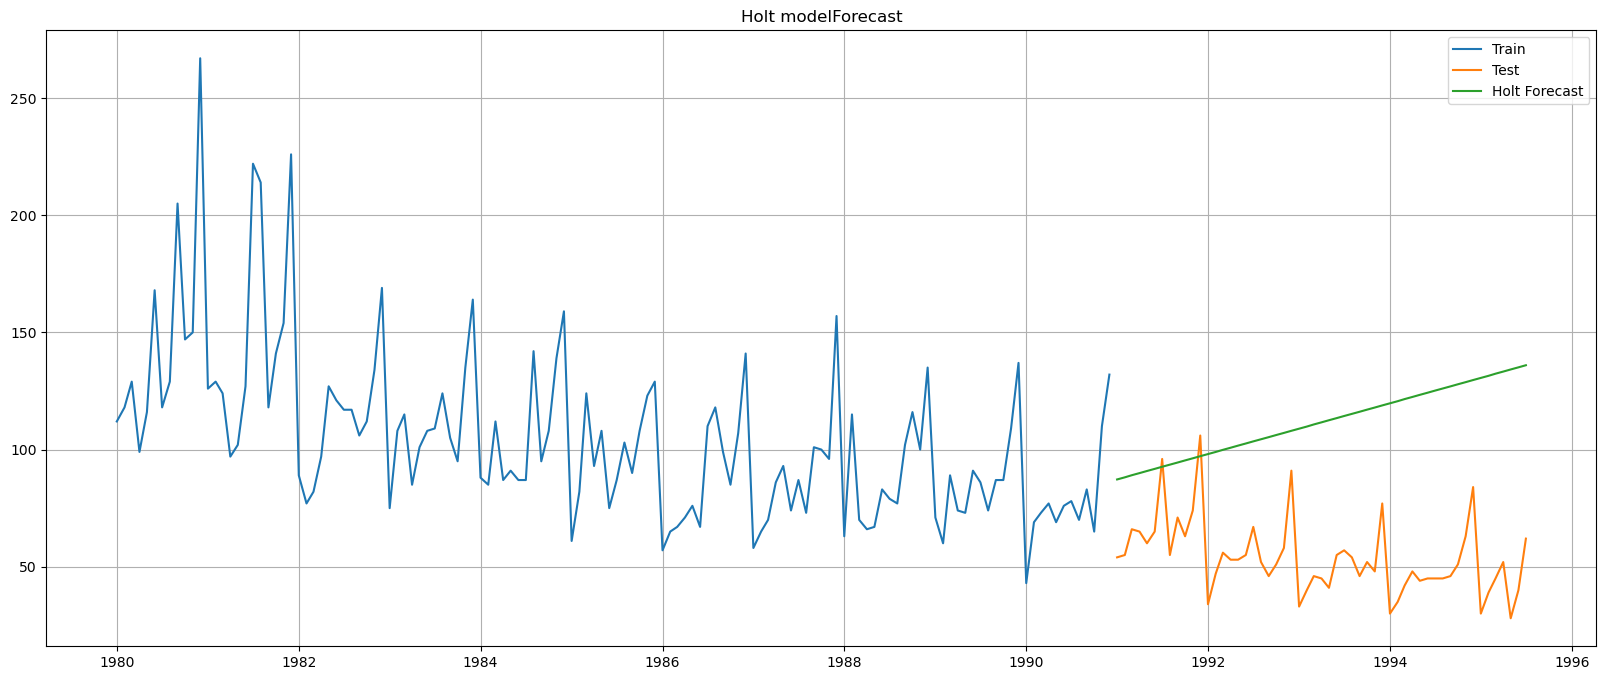

In [103]:
plt.plot(holt_train['Rose'],label='Train')
plt.plot(holt_test['Rose'],label='Test')
plt.plot(holt_test['predictions'],label='Holt Forecast')
plt.title('Holt modelForecast')
plt.legend(loc='best')
plt.grid();

In [104]:
holt_autofit_df=pd.DataFrame({'Test RMSE':rmse_holt},index=['HoltAutofit'])
holt_autofit_df

Test RMSE
HoltAutofit      63.07

In [105]:
results_df=pd.concat([results_df,holt_autofit_df])
results_df

Test RMSE
LinearRegression              15.28
NaiveForecast                 79.74
SimpleAvgForecast             53.48
MA_trail2                     11.53
MA_trail3                     14.13
MA_trail6                     14.57
MA_trail12                    15.24
SimpleExpSmoothing            37.61
SimpExpSmoothingAlpha0.1      36.85
HoltAutofit                   63.07

In [106]:
holt_alpha_df=pd.DataFrame({'Alpha':[],'Beta':[],'Rmse':[]})

In [107]:
for i in np.arange(0,1,0.1):
    for j in np.arange(0,1,0.1):
        holt_alpha=Holt(holt_train['Rose']).fit(smoothing_level=i,smoothing_trend=j,optimized=False)
        holt_test['predict',i]=holt_alpha.forecast(steps=len(holt_test))
        rmse_holt_alpha=np.sqrt(mean_squared_error(holt_test['Rose'],holt_test['predict',i]))
        holt_alpha_df=holt_alpha_df.append({'Alpha':i,'Beta':j,'Rmse':rmse_holt_alpha},ignore_index=True)
holt_alpha_df.sort_values(by='Rmse',ascending=True)

Alpha  Beta         Rmse
11    0.1   0.1    36.944741
12    0.1   0.2    48.711683
21    0.2   0.1    65.754737
13    0.1   0.3    78.180634
31    0.3   0.1    98.676734
..    ...   ...          ...
2     0.0   0.2  1023.328073
1     0.0   0.1  1023.328073
0     0.0   0.0  1023.328073
89    0.8   0.9  1052.489279
79    0.7   0.9  1061.872441

[100 rows x 3 columns]

In [109]:
holt_alpha_model=Holt(holt_train['Rose']).fit(smoothing_level=0.1,smoothing_trend=0.1,optimized=False)

In [110]:
holt_test['alpha predict']=holt_alpha_model.forecast(steps=len(holt_test))

In [111]:
rmse_holt_alpha_model=np.sqrt(mean_squared_error(holt_test['Rose'],holt_test['alpha predict'])).round(2)
rmse_holt_alpha_model

36.94

In [112]:
holt_alpha_model.params

{'smoothing_level': 0.1,
 'smoothing_trend': 0.1,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': 6.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

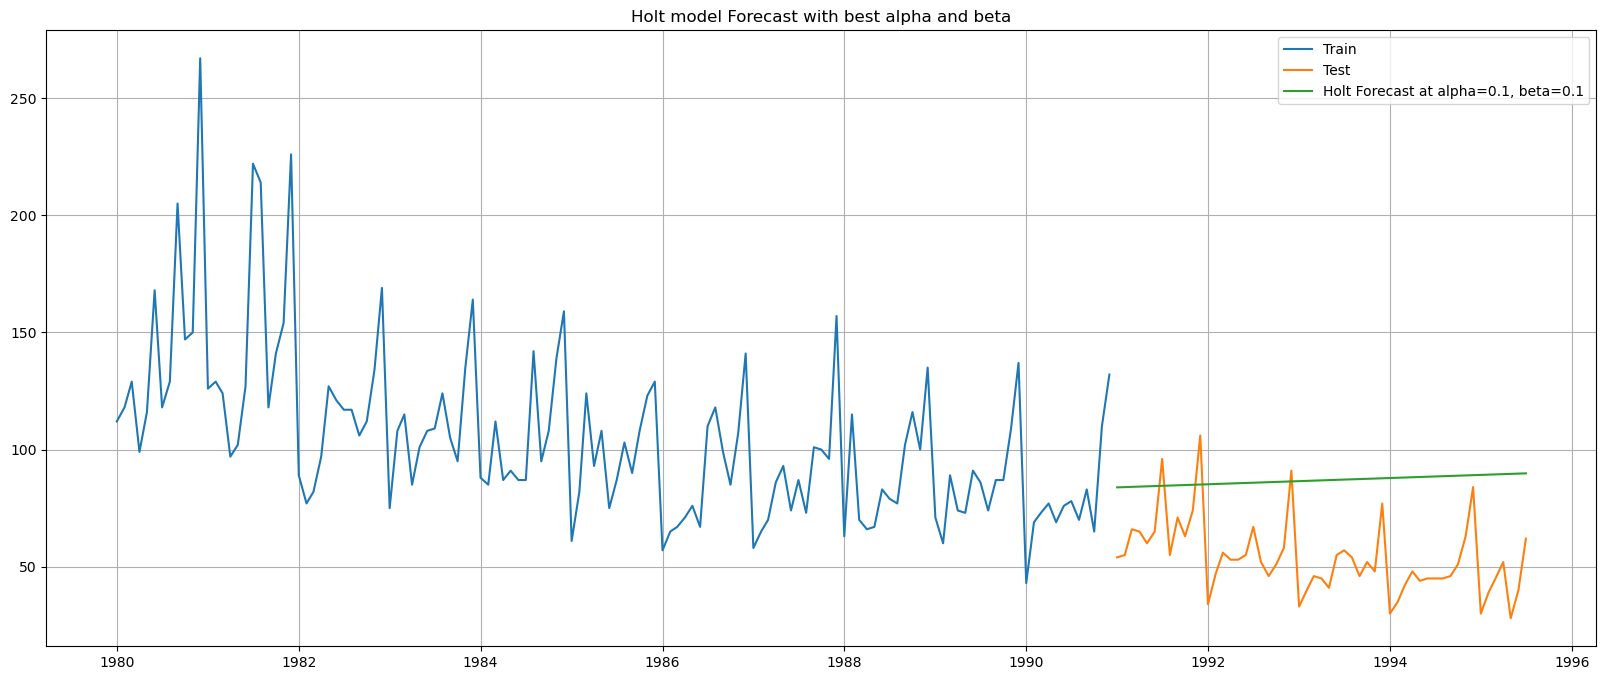

In [113]:
plt.plot(holt_train['Rose'],label='Train')
plt.plot(holt_test['Rose'],label='Test')
plt.plot(holt_test['alpha predict'],label='Holt Forecast at alpha=0.1, beta=0.1')
plt.title('Holt model Forecast with best alpha and beta')
plt.legend(loc='best')
plt.grid();

In [114]:
holt_alpha_model_results_df=pd.DataFrame({'Test RMSE':rmse_holt_alpha_model},index=['HoltBestAlphaBeta'])
holt_alpha_model_results_df

Test RMSE
HoltBestAlphaBeta      36.94

In [115]:
results_df=pd.concat([results_df,holt_alpha_model_results_df])
results_df

Test RMSE
LinearRegression              15.28
NaiveForecast                 79.74
SimpleAvgForecast             53.48
MA_trail2                     11.53
MA_trail3                     14.13
MA_trail6                     14.57
MA_trail12                    15.24
SimpleExpSmoothing            37.61
SimpExpSmoothingAlpha0.1      36.85
HoltAutofit                   63.07
HoltBestAlphaBeta             36.94

#### Holt-winters model

In [116]:
hw_train=train.copy()
hw_test=test.copy()

In [117]:
hw_model=ExponentialSmoothing(hw_train['Rose'],trend='additive',seasonal='multiplicative').fit(optimized=True)

In [118]:
hw_model.params

{'smoothing_level': 0.0715106306609405,
 'smoothing_trend': 0.04529179757535142,
 'smoothing_seasonal': 7.244325029450242e-05,
 'damping_trend': nan,
 'initial_level': 130.40839142502193,
 'initial_trend': -0.77985743179386,
 'initial_seasons': array([0.86218996, 0.977675  , 1.0687727 , 0.93403881, 1.050625  ,
        1.14410977, 1.25836944, 1.33937772, 1.26778766, 1.24131254,
        1.44724625, 1.99553681]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [119]:
hw_test['predictions']=hw_model.forecast(steps=len(hw_test))

In [120]:
rmse_hw=np.sqrt(mean_squared_error(hw_test['Rose'],hw_test['predictions'])).round(2)
rmse_hw

20.18

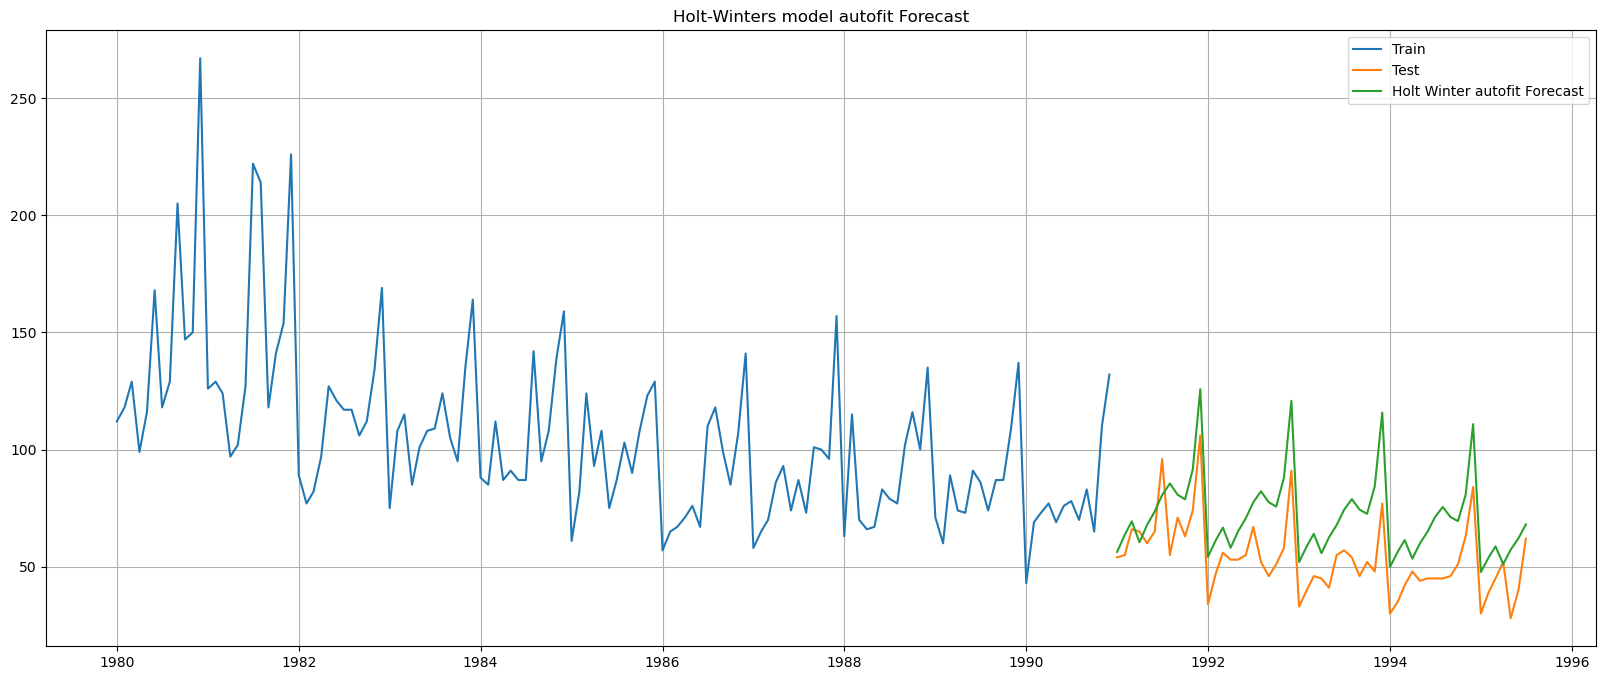

In [121]:
plt.plot(hw_train['Rose'],label='Train')
plt.plot(hw_test['Rose'],label='Test')
plt.plot(hw_test['predictions'],label='Holt Winter autofit Forecast')
plt.title('Holt-Winters model autofit Forecast')
plt.legend(loc='best')
plt.grid();

In [122]:
hw_df=pd.DataFrame({'Test RMSE':rmse_hw},index=['HoltWintersAutofit'])
hw_df

Test RMSE
HoltWintersAutofit      20.18

In [123]:
results_df=pd.concat([results_df,hw_df])
results_df

Test RMSE
LinearRegression              15.28
NaiveForecast                 79.74
SimpleAvgForecast             53.48
MA_trail2                     11.53
MA_trail3                     14.13
MA_trail6                     14.57
MA_trail12                    15.24
SimpleExpSmoothing            37.61
SimpExpSmoothingAlpha0.1      36.85
HoltAutofit                   63.07
HoltBestAlphaBeta             36.94
HoltWintersAutofit            20.18

In [124]:
hw_alpha_df=pd.DataFrame({'Alpha':[],'Beta':[],'Gamma':[],'RMSE Test':[]})

In [125]:
for i in np.arange(0,0.1,0.01):
    for j in np.arange(0,0.1,0.01):
        for k in np.arange(0,0.0001,0.00001):
            hw_alpha=ExponentialSmoothing(hw_train['Rose'],trend='additive',seasonal='multiplicative').fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k)
            hw_test['predict',i,j,k]=hw_alpha.forecast(steps=len(hw_test))
            rmse_hw_alpha=np.sqrt(mean_squared_error(hw_test['Rose'],hw_test['predict',i,j,k]))
            hw_alpha_df=hw_alpha_df.append({'Alpha':i,'Beta':j,'Gamma':k,'RMSE Test':rmse_hw_alpha},ignore_index=True)
hw_alpha_df.sort_values(by='RMSE Test')

Alpha  Beta    Gamma  RMSE Test
149   0.01  0.04  0.00009   8.443893
148   0.01  0.04  0.00008   8.443944
146   0.01  0.04  0.00006   8.443991
145   0.01  0.04  0.00005   8.444004
147   0.01  0.04  0.00007   8.444009
..     ...   ...      ...        ...
294   0.02  0.09  0.00004  29.218587
293   0.02  0.09  0.00003  29.218902
292   0.02  0.09  0.00002  29.219162
291   0.02  0.09  0.00001  29.219380
290   0.02  0.09  0.00000  29.219481

[1000 rows x 4 columns]

Observations:
- Here we can see that the best results are obtained with alpha=0.01, beta=0.04 and gamma=0.00009

In [126]:
hw_alpha_model=ExponentialSmoothing(hw_train['Rose'],trend='additive',seasonal='multiplicative').fit(smoothing_level=0.01,smoothing_trend=0.04, smoothing_seasonal=0.00009,optimized=False)

In [127]:
hw_alpha_model.params

{'smoothing_level': 0.01,
 'smoothing_trend': 0.04,
 'smoothing_seasonal': 9e-05,
 'damping_trend': nan,
 'initial_level': 145.27499999999992,
 'initial_trend': 0.7643939393939481,
 'initial_seasons': array([0.75572235, 0.80417408, 0.89051255, 0.75964172, 0.88067767,
        0.92553586, 1.08905952, 1.13538639, 1.03030222, 0.96585715,
        1.13788391, 1.62524659]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [128]:
hw_test['alpha predictions']=hw_alpha_model.forecast(steps=len(hw_test))

In [129]:
rmse_hw_alpha_model=np.sqrt(mean_squared_error(hw_test['Rose'],hw_test['alpha predictions'])).round(2)
rmse_hw_alpha_model

12.01

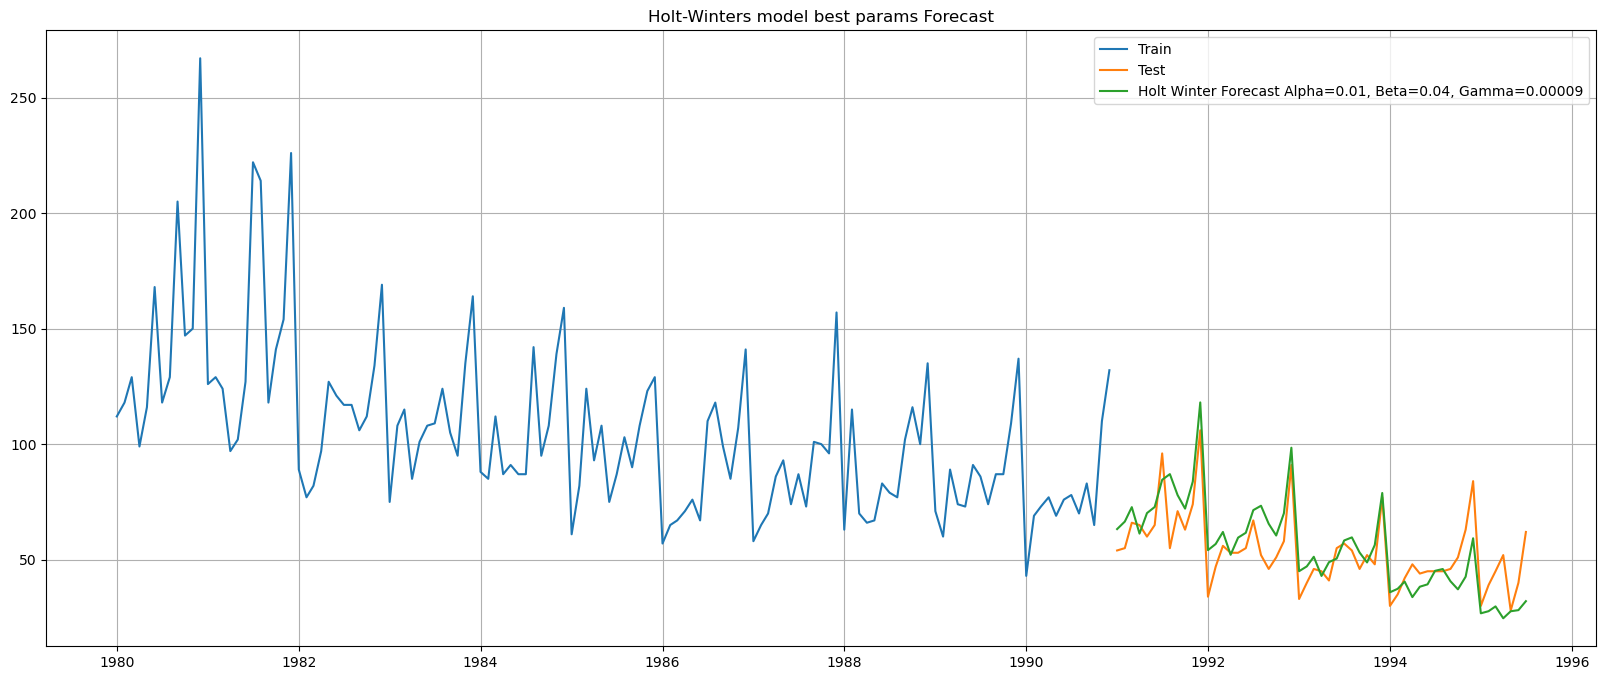

In [130]:
plt.plot(hw_train['Rose'],label='Train')
plt.plot(hw_test['Rose'],label='Test')
plt.plot(hw_test['alpha predictions'],label='Holt Winter Forecast Alpha=0.01, Beta=0.04, Gamma=0.00009')
plt.title('Holt-Winters model best params Forecast')
plt.legend(loc='best')
plt.grid();

In [131]:
hw_alpha_results_df=pd.DataFrame({'Test RMSE':rmse_hw_alpha_model},index=['HoltWintersalpha0.01beta0.04gamma0.00009'])
hw_alpha_results_df

Test RMSE
HoltWintersalpha0.01beta0.04gamma0.00009      12.01

In [132]:
results_df=pd.concat([results_df,hw_alpha_results_df])
results_df

Test RMSE
LinearRegression                              15.28
NaiveForecast                                 79.74
SimpleAvgForecast                             53.48
MA_trail2                                     11.53
MA_trail3                                     14.13
MA_trail6                                     14.57
MA_trail12                                    15.24
SimpleExpSmoothing                            37.61
SimpExpSmoothingAlpha0.1                      36.85
HoltAutofit                                   63.07
HoltBestAlphaBeta                             36.94
HoltWintersAutofit                            20.18
HoltWintersalpha0.01beta0.04gamma0.00009      12.01

## Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.

In [133]:
import itertools
p = q = range(0, 3)
d= range(0,2)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0],  x[1], x[2],12) for x in list(itertools.product(p,d,q))]
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

### ARIMA

In [134]:
arima_aic_df=pd.DataFrame(columns=['param','AIC'])

In [135]:
arima_train=train.copy()
arima_test=test.copy()

In [136]:
from statsmodels.tsa.arima.model import ARIMA

for param in pdq:
    arima_model = ARIMA(arima_train['Rose'], order=param)
    results_arima = arima_model.fit()
    print('ARIMA{} - AIC:{}'.format(param, results_arima.aic))
    arima_aic_df = arima_aic_df.append({'param':param, 'AIC': results_arima.aic}, ignore_index=True)

ARIMA(0, 0, 0) - AIC:1324.899702958276
ARIMA(0, 0, 1) - AIC:1305.4684058450507
ARIMA(0, 0, 2) - AIC:1306.5870153792748
ARIMA(0, 1, 0) - AIC:1333.1546729124348
ARIMA(0, 1, 1) - AIC:1282.3098319748312
ARIMA(0, 1, 2) - AIC:1279.6715288535806
ARIMA(1, 0, 0) - AIC:1301.5463044401158
ARIMA(1, 0, 1) - AIC:1294.5105853006132
ARIMA(1, 0, 2) - AIC:1292.0532131091868
ARIMA(1, 1, 0) - AIC:1317.3503105381492
ARIMA(1, 1, 1) - AIC:1280.5742295380064
ARIMA(1, 1, 2) - AIC:1279.8707234231915
ARIMA(2, 0, 0) - AIC:1302.3476849754175
ARIMA(2, 0, 1) - AIC:1292.9371947658196
ARIMA(2, 0, 2) - AIC:1292.2480553815885
ARIMA(2, 1, 0) - AIC:1298.611034160493
ARIMA(2, 1, 1) - AIC:1281.5078621868513
ARIMA(2, 1, 2) - AIC:1281.8707222264356


In [137]:
arima_aic_df.sort_values(by='AIC')

param          AIC
5   (0, 1, 2)  1279.671529
11  (1, 1, 2)  1279.870723
10  (1, 1, 1)  1280.574230
16  (2, 1, 1)  1281.507862
17  (2, 1, 2)  1281.870722
4   (0, 1, 1)  1282.309832
8   (1, 0, 2)  1292.053213
14  (2, 0, 2)  1292.248055
13  (2, 0, 1)  1292.937195
7   (1, 0, 1)  1294.510585
15  (2, 1, 0)  1298.611034
6   (1, 0, 0)  1301.546304
12  (2, 0, 0)  1302.347685
1   (0, 0, 1)  1305.468406
2   (0, 0, 2)  1306.587015
9   (1, 1, 0)  1317.350311
0   (0, 0, 0)  1324.899703
3   (0, 1, 0)  1333.154673

In [138]:
arima_best_model=ARIMA(arima_train['Rose'],order=(0,1,2)).fit()
print(arima_best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  132
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -636.836
Date:                Sat, 11 Nov 2023   AIC                           1279.672
Time:                        11:52:12   BIC                           1288.297
Sample:                    01-01-1980   HQIC                          1283.176
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6970      0.072     -9.689      0.000      -0.838      -0.556
ma.L2         -0.2042      0.073     -2.794      0.005      -0.347      -0.061
sigma2       965.8407     88.305     10.938      0.0

In [139]:
arima_test['predictions']=arima_best_model.forecast(steps=len(arima_test))

In [140]:
rmse_arima=np.sqrt(mean_squared_error(arima_test['Rose'],arima_test['predictions'])).round(2)
rmse_arima

37.33

In [141]:
arima_results=pd.DataFrame({'Test RMSE': rmse_arima},index=['ARIMA'])
arima_results

Test RMSE
ARIMA      37.33

In [142]:
results_df=pd.concat([results_df,arima_results])
results_df

Test RMSE
LinearRegression                              15.28
NaiveForecast                                 79.74
SimpleAvgForecast                             53.48
MA_trail2                                     11.53
MA_trail3                                     14.13
MA_trail6                                     14.57
MA_trail12                                    15.24
SimpleExpSmoothing                            37.61
SimpExpSmoothingAlpha0.1                      36.85
HoltAutofit                                   63.07
HoltBestAlphaBeta                             36.94
HoltWintersAutofit                            20.18
HoltWintersalpha0.01beta0.04gamma0.00009      12.01
ARIMA                                         37.33

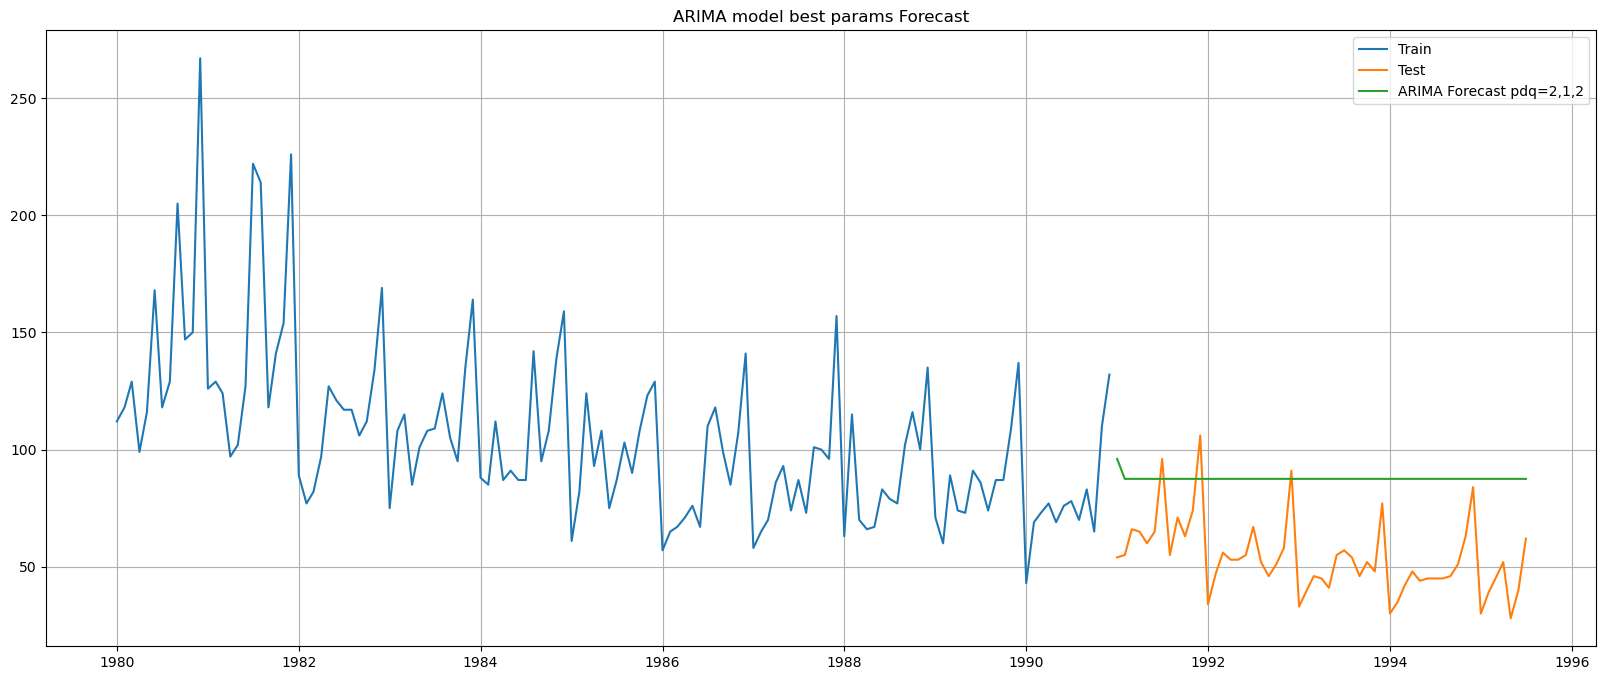

In [143]:
plt.plot(arima_train['Rose'],label='Train')
plt.plot(arima_test['Rose'],label='Test')
plt.plot(arima_test['predictions'],label='ARIMA Forecast pdq=2,1,2')
plt.title('ARIMA model best params Forecast')
plt.legend(loc='best')
plt.grid();

### SARIMA

In [144]:
sarima_train=train.copy()
sarima_test=test.copy()

In [145]:
sarima_df = pd.DataFrame(columns=['param','seasonal', 'AIC'])
sarima_df

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

In [146]:
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in model_pdq:
        sarima_model = sm.tsa.statespace.SARIMAX(sarima_train['Rose'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False).fit()
        print('SARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, sarima_model.aic))
        sarima_df = sarima_df.append({'param':param,'seasonal':param_seasonal ,'AIC': sarima_model.aic}, ignore_index=True)
sarima_df       

SARIMA(0, 0, 0)x(0, 0, 0, 12)7 - AIC:1607.5307543879908
SARIMA(0, 0, 0)x(0, 0, 1, 12)7 - AIC:1342.887979632014
SARIMA(0, 0, 0)x(0, 0, 2, 12)7 - AIC:1127.6939671247933
SARIMA(0, 0, 0)x(0, 1, 0, 12)7 - AIC:1132.3491004641107
SARIMA(0, 0, 0)x(0, 1, 1, 12)7 - AIC:973.2839647242952
SARIMA(0, 0, 0)x(0, 1, 2, 12)7 - AIC:819.2632583151208
SARIMA(0, 0, 0)x(1, 0, 0, 12)7 - AIC:1123.327544387293
SARIMA(0, 0, 0)x(1, 0, 1, 12)7 - AIC:1072.6552135795077
SARIMA(0, 0, 0)x(1, 0, 2, 12)7 - AIC:947.516631502675
SARIMA(0, 0, 0)x(1, 1, 0, 12)7 - AIC:982.5608243528003
SARIMA(0, 0, 0)x(1, 1, 1, 12)7 - AIC:970.9074505848829
SARIMA(0, 0, 0)x(1, 1, 2, 12)7 - AIC:821.1204806448416
SARIMA(0, 0, 0)x(2, 0, 0, 12)7 - AIC:939.9681316162017
SARIMA(0, 0, 0)x(2, 0, 1, 12)7 - AIC:941.4830987726807
SARIMA(0, 0, 0)x(2, 0, 2, 12)7 - AIC:931.5268657510487
SARIMA(0, 0, 0)x(2, 1, 0, 12)7 - AIC:828.5116218528785
SARIMA(0, 0, 0)x(2, 1, 1, 12)7 - AIC:822.8736935508689
SARIMA(0, 0, 0)x(2, 1, 2, 12)7 - AIC:814.9165422328676
SARIMA(

C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 0, 1)x(2, 0, 1, 12)7 - AIC:936.2318332252647
SARIMA(0, 0, 1)x(2, 0, 2, 12)7 - AIC:915.769456974753
SARIMA(0, 0, 1)x(2, 1, 0, 12)7 - AIC:825.992719650093
SARIMA(0, 0, 1)x(2, 1, 1, 12)7 - AIC:821.7035173542931
SARIMA(0, 0, 1)x(2, 1, 2, 12)7 - AIC:803.5464654607332
SARIMA(0, 0, 2)x(0, 0, 0, 12)7 - AIC:1426.8445495317037
SARIMA(0, 0, 2)x(0, 0, 1, 12)7 - AIC:1196.6906694095178
SARIMA(0, 0, 2)x(0, 0, 2, 12)7 - AIC:1021.9681627947015
SARIMA(0, 0, 2)x(0, 1, 0, 12)7 - AIC:1106.24199879359
SARIMA(0, 0, 2)x(0, 1, 1, 12)7 - AIC:929.908750822315
SARIMA(0, 0, 2)x(0, 1, 2, 12)7 - AIC:800.4805045656319
SARIMA(0, 0, 2)x(1, 0, 0, 12)7 - AIC:1115.1844523431992
SARIMA(0, 0, 2)x(1, 0, 1, 12)7 - AIC:1052.0368663958673


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 0, 2)x(1, 0, 2, 12)7 - AIC:925.9495379920055
SARIMA(0, 0, 2)x(1, 1, 0, 12)7 - AIC:961.7175036338392
SARIMA(0, 0, 2)x(1, 1, 1, 12)7 - AIC:933.3024776192742
SARIMA(0, 0, 2)x(1, 1, 2, 12)7 - AIC:802.3231410466967
SARIMA(0, 0, 2)x(2, 0, 0, 12)7 - AIC:934.677629682266
SARIMA(0, 0, 2)x(2, 0, 1, 12)7 - AIC:936.6693500003545
SARIMA(0, 0, 2)x(2, 0, 2, 12)7 - AIC:907.1203154308472
SARIMA(0, 0, 2)x(2, 1, 0, 12)7 - AIC:826.8304039101001
SARIMA(0, 0, 2)x(2, 1, 1, 12)7 - AIC:823.3580231271653
SARIMA(0, 0, 2)x(2, 1, 2, 12)7 - AIC:794.5290230651291
SARIMA(0, 1, 0)x(0, 0, 0, 12)7 - AIC:1323.9657875279158
SARIMA(0, 1, 0)x(0, 0, 1, 12)7 - AIC:1145.4230827207175
SARIMA(0, 1, 0)x(0, 0, 2, 12)7 - AIC:976.4375296380894
SARIMA(0, 1, 0)x(0, 1, 0, 12)7 - AIC:1171.2013438279514
SARIMA(0, 1, 0)x(0, 1, 1, 12)7 - AIC:965.5057301627294
SARIMA(0, 1, 0)x(0, 1, 2, 12)7 - AIC:845.8687014776131
SARIMA(0, 1, 0)x(1, 0, 0, 12)7 - AIC:1139.921738995602
SARIMA(0, 1, 0)x(1, 0, 1, 12)7 - AIC:1116.0207869386002
SARIMA(

C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 0)x(2, 0, 1, 12)7 - AIC:962.8794540697546
SARIMA(0, 1, 0)x(2, 0, 2, 12)7 - AIC:955.5735408945653
SARIMA(0, 1, 0)x(2, 1, 0, 12)7 - AIC:858.5132698374416
SARIMA(0, 1, 0)x(2, 1, 1, 12)7 - AIC:853.3390729144143
SARIMA(0, 1, 0)x(2, 1, 2, 12)7 - AIC:842.628224422131
SARIMA(0, 1, 1)x(0, 0, 0, 12)7 - AIC:1263.5369097383968
SARIMA(0, 1, 1)x(0, 0, 1, 12)7 - AIC:1098.5554825918339
SARIMA(0, 1, 1)x(0, 0, 2, 12)7 - AIC:923.6314049383869
SARIMA(0, 1, 1)x(0, 1, 0, 12)7 - AIC:1113.7663133563515
SARIMA(0, 1, 1)x(0, 1, 1, 12)7 - AIC:915.0730606717417
SARIMA(0, 1, 1)x(0, 1, 2, 12)7 - AIC:790.9032809266309
SARIMA(0, 1, 1)x(1, 0, 0, 12)7 - AIC:1095.7936324918292
SARIMA(0, 1, 1)x(1, 0, 1, 12)7 - AIC:1054.7434330945698
SARIMA(0, 1, 1)x(1, 0, 2, 12)7 - AIC:918.8573483293343
SARIMA(0, 1, 1)x(1, 1, 0, 12)7 - AIC:944.2456655529988
SARIMA(0, 1, 1)x(1, 1, 1, 12)7 - AIC:929.3362488520078
SARIMA(0, 1, 1)x(1, 1, 2, 12)7 - AIC:792.7161670332863
SARIMA(0, 1, 1)x(2, 0, 0, 12)7 - AIC:914.5982866536139
SARIMA

C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 1)x(2, 0, 2, 12)7 - AIC:901.2037192888771
SARIMA(0, 1, 1)x(2, 1, 0, 12)7 - AIC:810.3194350158678
SARIMA(0, 1, 1)x(2, 1, 1, 12)7 - AIC:804.1555752546934
SARIMA(0, 1, 1)x(2, 1, 2, 12)7 - AIC:782.1538715246272
SARIMA(0, 1, 2)x(0, 0, 0, 12)7 - AIC:1251.667543054105
SARIMA(0, 1, 2)x(0, 0, 1, 12)7 - AIC:1083.4866975264854
SARIMA(0, 1, 2)x(0, 0, 2, 12)7 - AIC:913.4938486617709
SARIMA(0, 1, 2)x(0, 1, 0, 12)7 - AIC:1098.6598024292612
SARIMA(0, 1, 2)x(0, 1, 1, 12)7 - AIC:904.500348847232
SARIMA(0, 1, 2)x(0, 1, 2, 12)7 - AIC:784.0140955703721
SARIMA(0, 1, 2)x(1, 0, 0, 12)7 - AIC:1088.833284341405
SARIMA(0, 1, 2)x(1, 0, 1, 12)7 - AIC:1045.5400933578762
SARIMA(0, 1, 2)x(1, 0, 2, 12)7 - AIC:904.8310913581822
SARIMA(0, 1, 2)x(1, 1, 0, 12)7 - AIC:941.5256923362657
SARIMA(0, 1, 2)x(1, 1, 1, 12)7 - AIC:915.273113409056
SARIMA(0, 1, 2)x(1, 1, 2, 12)7 - AIC:785.8237144293379
SARIMA(0, 1, 2)x(2, 0, 0, 12)7 - AIC:913.0105912257945
SARIMA(0, 1, 2)x(2, 0, 1, 12)7 - AIC:914.1707545034674
SARIMA(0,

C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 1)x(1, 1, 1, 12)7 - AIC:925.4416344659286


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 1)x(1, 1, 2, 12)7 - AIC:802.6808817459198
SARIMA(1, 0, 1)x(2, 0, 0, 12)7 - AIC:916.2903570224845


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 1)x(2, 0, 1, 12)7 - AIC:934.0304480927699
SARIMA(1, 0, 1)x(2, 0, 2, 12)7 - AIC:916.3527636794988
SARIMA(1, 0, 1)x(2, 1, 0, 12)7 - AIC:807.910543936121
SARIMA(1, 0, 1)x(2, 1, 1, 12)7 - AIC:803.8435639880204


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 1)x(2, 1, 2, 12)7 - AIC:791.1085764727877
SARIMA(1, 0, 2)x(0, 0, 0, 12)7 - AIC:1258.7656242378584
SARIMA(1, 0, 2)x(0, 0, 1, 12)7 - AIC:1088.1787539652169


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 2)x(0, 0, 2, 12)7 - AIC:973.0414490153195
SARIMA(1, 0, 2)x(0, 1, 0, 12)7 - AIC:1105.2936494512012
SARIMA(1, 0, 2)x(0, 1, 1, 12)7 - AIC:909.4621536200244
SARIMA(1, 0, 2)x(0, 1, 2, 12)7 - AIC:787.0708545284807
SARIMA(1, 0, 2)x(1, 0, 0, 12)7 - AIC:1087.091503933505


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 2)x(1, 0, 1, 12)7 - AIC:1054.882347289766


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 2)x(1, 0, 2, 12)7 - AIC:915.1393450232817
SARIMA(1, 0, 2)x(1, 1, 0, 12)7 - AIC:934.4242986993037
SARIMA(1, 0, 2)x(1, 1, 1, 12)7 - AIC:919.5722540700515
SARIMA(1, 0, 2)x(1, 1, 2, 12)7 - AIC:788.3877526141497


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 2)x(2, 0, 0, 12)7 - AIC:914.687388651912
SARIMA(1, 0, 2)x(2, 0, 1, 12)7 - AIC:932.0304670804425


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 2)x(2, 0, 2, 12)7 - AIC:900.2651653796781
SARIMA(1, 0, 2)x(2, 1, 0, 12)7 - AIC:809.1023799333158
SARIMA(1, 0, 2)x(2, 1, 1, 12)7 - AIC:808.5333666199409


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 2)x(2, 1, 2, 12)7 - AIC:781.1194266894345
SARIMA(1, 1, 0)x(0, 0, 0, 12)7 - AIC:1308.161871082466
SARIMA(1, 1, 0)x(0, 0, 1, 12)7 - AIC:1135.2955447585698
SARIMA(1, 1, 0)x(0, 0, 2, 12)7 - AIC:963.940539125769
SARIMA(1, 1, 0)x(0, 1, 0, 12)7 - AIC:1164.5103013842067
SARIMA(1, 1, 0)x(0, 1, 1, 12)7 - AIC:953.8813887547306
SARIMA(1, 1, 0)x(0, 1, 2, 12)7 - AIC:828.8398832821209
SARIMA(1, 1, 0)x(1, 0, 0, 12)7 - AIC:1124.886078680458
SARIMA(1, 1, 0)x(1, 0, 1, 12)7 - AIC:1105.4080055023908
SARIMA(1, 1, 0)x(1, 0, 2, 12)7 - AIC:958.5001972948193
SARIMA(1, 1, 0)x(1, 1, 0, 12)7 - AIC:962.9698535736659
SARIMA(1, 1, 0)x(1, 1, 1, 12)7 - AIC:964.8516934823648
SARIMA(1, 1, 0)x(1, 1, 2, 12)7 - AIC:830.307580496708
SARIMA(1, 1, 0)x(2, 0, 0, 12)7 - AIC:939.0984778664119
SARIMA(1, 1, 0)x(2, 0, 1, 12)7 - AIC:940.9087133661066
SARIMA(1, 1, 0)x(2, 0, 2, 12)7 - AIC:942.2973103071328
SARIMA(1, 1, 0)x(2, 1, 0, 12)7 - AIC:826.9995808091124
SARIMA(1, 1, 0)x(2, 1, 1, 12)7 - AIC:823.8261102781044
SARIMA(1,

C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 2)x(1, 0, 2, 12)7 - AIC:906.7349112543739
SARIMA(1, 1, 2)x(1, 1, 0, 12)7 - AIC:934.8870392437676
SARIMA(1, 1, 2)x(1, 1, 1, 12)7 - AIC:917.2527818412
SARIMA(1, 1, 2)x(1, 1, 2, 12)7 - AIC:787.784397022405
SARIMA(1, 1, 2)x(2, 0, 0, 12)7 - AIC:906.1690196598709
SARIMA(1, 1, 2)x(2, 0, 1, 12)7 - AIC:907.4597828008443


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 2)x(2, 0, 2, 12)7 - AIC:899.4719661198988
SARIMA(1, 1, 2)x(2, 1, 0, 12)7 - AIC:801.9382052144458


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 2)x(2, 1, 1, 12)7 - AIC:791.917121612925
SARIMA(1, 1, 2)x(2, 1, 2, 12)7 - AIC:776.9401082351831
SARIMA(2, 0, 0)x(0, 0, 0, 12)7 - AIC:1308.2736030498356
SARIMA(2, 0, 0)x(0, 0, 1, 12)7 - AIC:1144.0819681754606
SARIMA(2, 0, 0)x(0, 0, 2, 12)7 - AIC:975.8159073680386
SARIMA(2, 0, 0)x(0, 1, 0, 12)7 - AIC:1116.4420654124233
SARIMA(2, 0, 0)x(0, 1, 1, 12)7 - AIC:947.1418397552204
SARIMA(2, 0, 0)x(0, 1, 2, 12)7 - AIC:819.2090528395814
SARIMA(2, 0, 0)x(1, 0, 0, 12)7 - AIC:1097.8439350588662
SARIMA(2, 0, 0)x(1, 0, 1, 12)7 - AIC:1061.8289040085906
SARIMA(2, 0, 0)x(1, 0, 2, 12)7 - AIC:940.2282324954236
SARIMA(2, 0, 0)x(1, 1, 0, 12)7 - AIC:940.3454236219314
SARIMA(2, 0, 0)x(1, 1, 1, 12)7 - AIC:942.1613088639232
SARIMA(2, 0, 0)x(1, 1, 2, 12)7 - AIC:821.0430855649948
SARIMA(2, 0, 0)x(2, 0, 0, 12)7 - AIC:916.4595541129352
SARIMA(2, 0, 0)x(2, 0, 1, 12)7 - AIC:918.4101007239882
SARIMA(2, 0, 0)x(2, 0, 2, 12)7 - AIC:916.2460072966009
SARIMA(2, 0, 0)x(2, 1, 0, 12)7 - AIC:807.9245922112272
SARIMA

C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 1)x(0, 0, 1, 12)7 - AIC:1100.9247580334775


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 1)x(0, 0, 2, 12)7 - AIC:929.7618553118169
SARIMA(2, 0, 1)x(0, 1, 0, 12)7 - AIC:1114.8308429099047
SARIMA(2, 0, 1)x(0, 1, 1, 12)7 - AIC:919.6392267576257
SARIMA(2, 0, 1)x(0, 1, 2, 12)7 - AIC:801.1525193804911
SARIMA(2, 0, 1)x(1, 0, 0, 12)7 - AIC:1082.0734254107217


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 1)x(1, 0, 1, 12)7 - AIC:1065.259084141029
SARIMA(2, 0, 1)x(1, 0, 2, 12)7 - AIC:935.0198987483125
SARIMA(2, 0, 1)x(1, 1, 0, 12)7 - AIC:926.0468857044118
SARIMA(2, 0, 1)x(1, 1, 1, 12)7 - AIC:928.0265317323077
SARIMA(2, 0, 1)x(1, 1, 2, 12)7 - AIC:801.8861086725657


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 1)x(2, 0, 0, 12)7 - AIC:907.3157129128243


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 1)x(2, 0, 1, 12)7 - AIC:908.8841888571009


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 1)x(2, 0, 2, 12)7 - AIC:916.1400067454397
SARIMA(2, 0, 1)x(2, 1, 0, 12)7 - AIC:798.1114883215505


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 1)x(2, 1, 1, 12)7 - AIC:792.9874356073723


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 1)x(2, 1, 2, 12)7 - AIC:792.8910312226652
SARIMA(2, 0, 2)x(0, 0, 0, 12)7 - AIC:1258.6801764024744


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 2)x(0, 0, 1, 12)7 - AIC:1105.5538766905495
SARIMA(2, 0, 2)x(0, 0, 2, 12)7 - AIC:925.1577353815968
SARIMA(2, 0, 2)x(0, 1, 0, 12)7 - AIC:1104.782155781061
SARIMA(2, 0, 2)x(0, 1, 1, 12)7 - AIC:910.2624320923895


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 2)x(0, 1, 2, 12)7 - AIC:788.9535286246019


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 2)x(1, 0, 0, 12)7 - AIC:1079.8055110417547


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 2)x(1, 0, 1, 12)7 - AIC:1060.9690549740155


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 2)x(1, 0, 2, 12)7 - AIC:925.6829487462579
SARIMA(2, 0, 2)x(1, 1, 0, 12)7 - AIC:927.6079831200941


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 2)x(1, 1, 1, 12)7 - AIC:912.2382319409454


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 2)x(1, 1, 2, 12)7 - AIC:790.3319877145753


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 2)x(2, 0, 0, 12)7 - AIC:909.1941234393336


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 2)x(2, 0, 1, 12)7 - AIC:911.0608501065568


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 2)x(2, 0, 2, 12)7 - AIC:911.1434507458883
SARIMA(2, 0, 2)x(2, 1, 0, 12)7 - AIC:800.1065825059356


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 2)x(2, 1, 1, 12)7 - AIC:791.2292450440405


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 2)x(2, 1, 2, 12)7 - AIC:782.0927382487196
SARIMA(2, 1, 0)x(0, 0, 0, 12)7 - AIC:1280.253756153577
SARIMA(2, 1, 0)x(0, 0, 1, 12)7 - AIC:1128.777370471139
SARIMA(2, 1, 0)x(0, 0, 2, 12)7 - AIC:958.079320882996
SARIMA(2, 1, 0)x(0, 1, 0, 12)7 - AIC:1133.246770439665
SARIMA(2, 1, 0)x(0, 1, 1, 12)7 - AIC:949.5332566879779
SARIMA(2, 1, 0)x(0, 1, 2, 12)7 - AIC:827.1933387102589
SARIMA(2, 1, 0)x(1, 0, 0, 12)7 - AIC:1099.508602157591
SARIMA(2, 1, 0)x(1, 0, 1, 12)7 - AIC:1076.786319864115
SARIMA(2, 1, 0)x(1, 0, 2, 12)7 - AIC:951.1988165558947
SARIMA(2, 1, 0)x(1, 1, 0, 12)7 - AIC:950.2637728228547
SARIMA(2, 1, 0)x(1, 1, 1, 12)7 - AIC:952.2623518887128
SARIMA(2, 1, 0)x(1, 1, 2, 12)7 - AIC:828.719870093335
SARIMA(2, 1, 0)x(2, 0, 0, 12)7 - AIC:924.6004792645451
SARIMA(2, 1, 0)x(2, 0, 1, 12)7 - AIC:925.9757801384721
SARIMA(2, 1, 0)x(2, 0, 2, 12)7 - AIC:927.8380693280806
SARIMA(2, 1, 0)x(2, 1, 0, 12)7 - AIC:814.2969261794622
SARIMA(2, 1, 0)x(2, 1, 1, 12)7 - AIC:808.5100914942311
SARIMA(2, 1,

C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(0, 1, 2, 12)7 - AIC:784.1447937546544
SARIMA(2, 1, 2)x(1, 0, 0, 12)7 - AIC:1073.2912713674077


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(1, 0, 1, 12)7 - AIC:1044.190935490377
SARIMA(2, 1, 2)x(1, 0, 2, 12)7 - AIC:907.6661488801619
SARIMA(2, 1, 2)x(1, 1, 0, 12)7 - AIC:925.3705667554225


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(1, 1, 1, 12)7 - AIC:915.6932510051558


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(1, 1, 2, 12)7 - AIC:786.1024941784211
SARIMA(2, 1, 2)x(2, 0, 0, 12)7 - AIC:897.3464441348879
SARIMA(2, 1, 2)x(2, 0, 1, 12)7 - AIC:898.3781888932879
SARIMA(2, 1, 2)x(2, 0, 2, 12)7 - AIC:890.6687981666225
SARIMA(2, 1, 2)x(2, 1, 0, 12)7 - AIC:794.7799442940219
SARIMA(2, 1, 2)x(2, 1, 1, 12)7 - AIC:783.703652281704


C:\Users\India\anaconda31\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(2, 1, 2, 12)7 - AIC:777.9117447872683


param       seasonal          AIC
0    (0, 0, 0)  (0, 0, 0, 12)  1607.530754
1    (0, 0, 0)  (0, 0, 1, 12)  1342.887980
2    (0, 0, 0)  (0, 0, 2, 12)  1127.693967
3    (0, 0, 0)  (0, 1, 0, 12)  1132.349100
4    (0, 0, 0)  (0, 1, 1, 12)   973.283965
..         ...            ...          ...
319  (2, 1, 2)  (2, 0, 1, 12)   898.378189
320  (2, 1, 2)  (2, 0, 2, 12)   890.668798
321  (2, 1, 2)  (2, 1, 0, 12)   794.779944
322  (2, 1, 2)  (2, 1, 1, 12)   783.703652
323  (2, 1, 2)  (2, 1, 2, 12)   777.911745

[324 rows x 3 columns]

In [147]:
sarima_df.sort_values(by='AIC')

param       seasonal          AIC
107  (0, 1, 2)  (2, 1, 2, 12)   774.969119
215  (1, 1, 2)  (2, 1, 2, 12)   776.940108
323  (2, 1, 2)  (2, 1, 2, 12)   777.911745
161  (1, 0, 2)  (2, 1, 2, 12)   781.119427
269  (2, 0, 2)  (2, 1, 2, 12)   782.092738
..         ...            ...          ...
108  (1, 0, 0)  (0, 0, 0, 12)  1331.248484
1    (0, 0, 0)  (0, 0, 1, 12)  1342.887980
36   (0, 0, 2)  (0, 0, 0, 12)  1426.844550
18   (0, 0, 1)  (0, 0, 0, 12)  1481.819865
0    (0, 0, 0)  (0, 0, 0, 12)  1607.530754

[324 rows x 3 columns]

In [148]:
sarima_best_model = sm.tsa.statespace.SARIMAX(sarima_train['Rose'],
                                order=(0,1,2),
                                seasonal_order=(2,1,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
print(sarima_best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Rose   No. Observations:                  132
Model:             SARIMAX(0, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -380.485
Date:                            Sat, 11 Nov 2023   AIC                            774.969
Time:                                    12:00:48   BIC                            792.622
Sample:                                01-01-1980   HQIC                           782.094
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9524      0.184     -5.166      0.000      -1.314      -0.591
ma.L2         -0.0764      0.126   

In [149]:
sarima_test['predictions']=sarima_best_model.forecast(steps=len(sarima_test))

In [150]:
rmse_sarima=np.sqrt(mean_squared_error(sarima_test['Rose'],sarima_test['predictions'])).round(2)
rmse_sarima

16.52

In [152]:
sarima_results=pd.DataFrame({'Test RMSE': rmse_sarima},index=['SARIMA'])
sarima_results

Test RMSE
SARIMA      16.52

In [153]:
results_df=pd.concat([results_df,sarima_results])
results_df

Test RMSE
LinearRegression                              15.28
NaiveForecast                                 79.74
SimpleAvgForecast                             53.48
MA_trail2                                     11.53
MA_trail3                                     14.13
MA_trail6                                     14.57
MA_trail12                                    15.24
SimpleExpSmoothing                            37.61
SimpExpSmoothingAlpha0.1                      36.85
HoltAutofit                                   63.07
HoltBestAlphaBeta                             36.94
HoltWintersAutofit                            20.18
HoltWintersalpha0.01beta0.04gamma0.00009      12.01
ARIMA                                         37.33
SARIMA                                        16.52

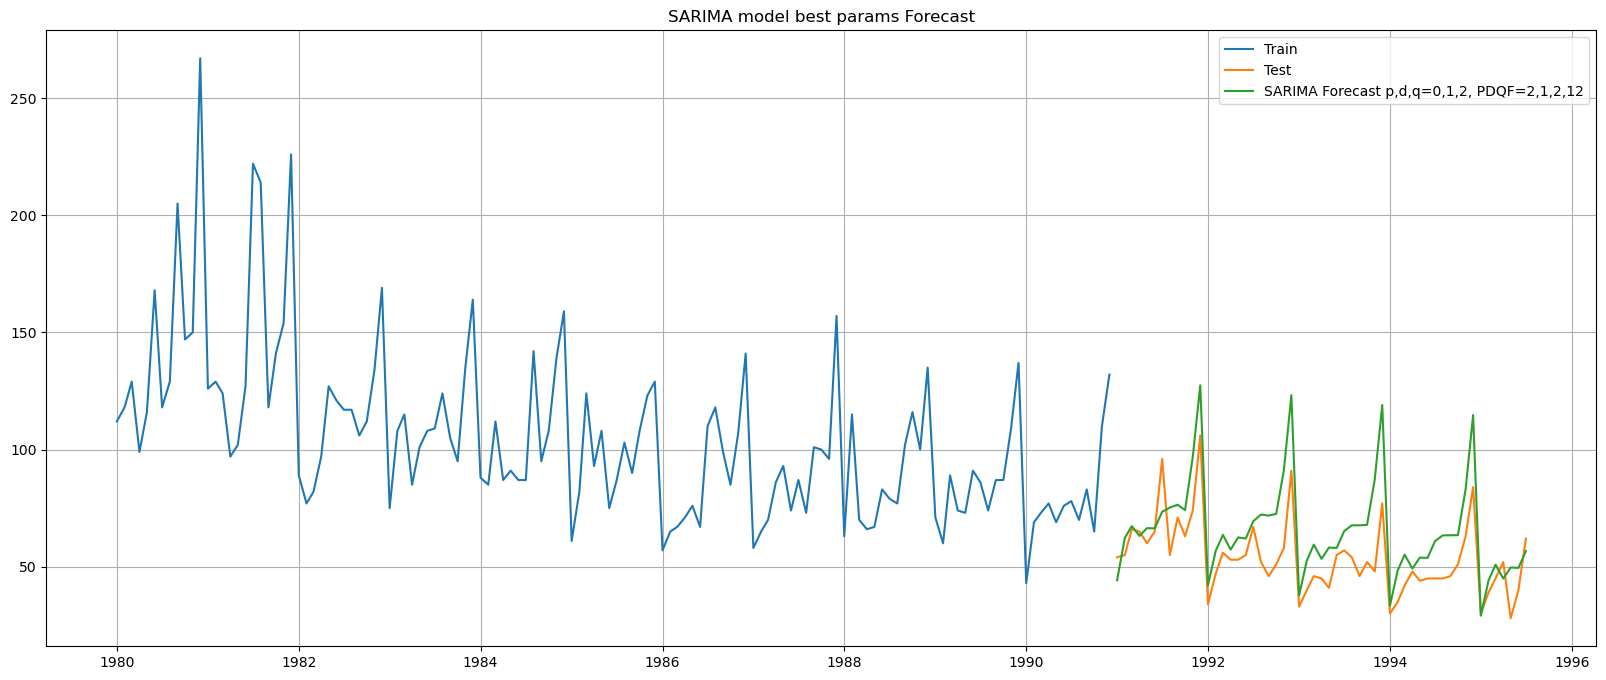

In [154]:
plt.plot(sarima_train['Rose'],label='Train')
plt.plot(sarima_test['Rose'],label='Test')
plt.plot(sarima_test['predictions'],label='SARIMA Forecast p,d,q=0,1,2, PDQF=2,1,2,12')
plt.title('SARIMA model best params Forecast')
plt.legend(loc='best')
plt.grid();

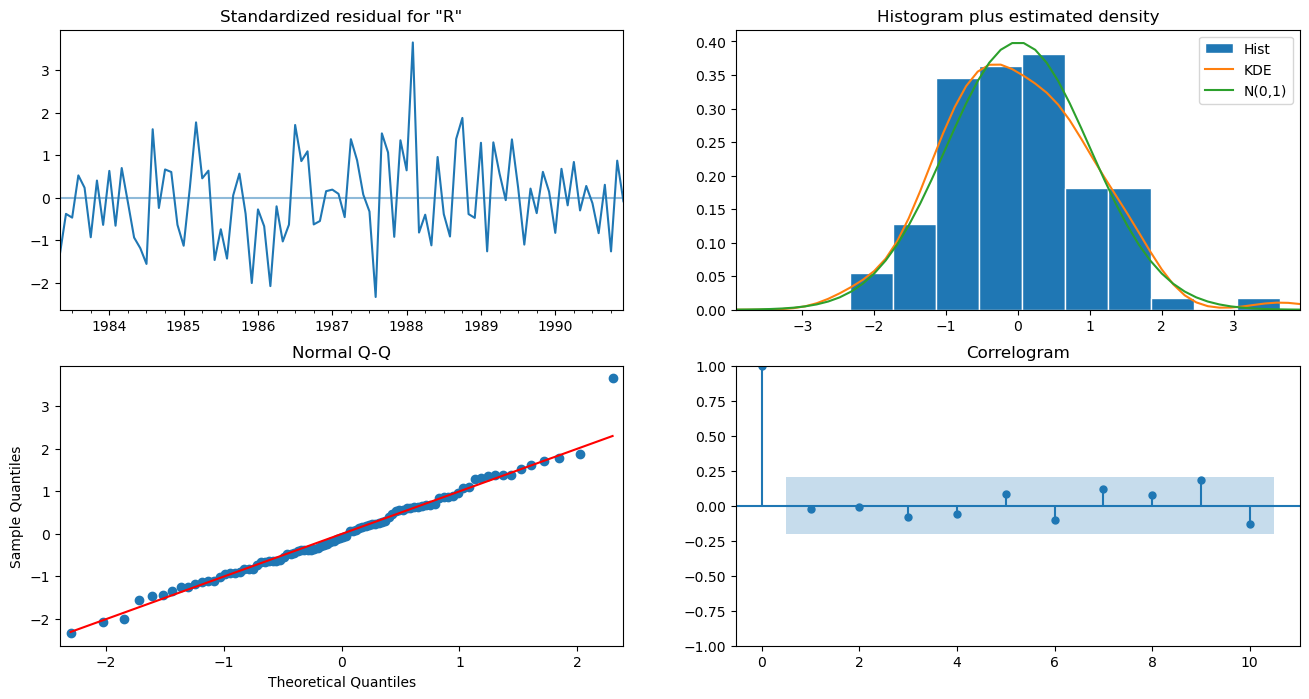

In [155]:
sarima_best_model.plot_diagnostics(figsize=(16, 8))
plt.show()

## Build a table with all the models built along with their corresponding parameters and the respective RMSE values on the test data.

In [156]:
results_df

Test RMSE
LinearRegression                              15.28
NaiveForecast                                 79.74
SimpleAvgForecast                             53.48
MA_trail2                                     11.53
MA_trail3                                     14.13
MA_trail6                                     14.57
MA_trail12                                    15.24
SimpleExpSmoothing                            37.61
SimpExpSmoothingAlpha0.1                      36.85
HoltAutofit                                   63.07
HoltBestAlphaBeta                             36.94
HoltWintersAutofit                            20.18
HoltWintersalpha0.01beta0.04gamma0.00009      12.01
ARIMA                                         37.33
SARIMA                                        16.52

In [157]:
results_df.sort_values(by='Test RMSE')

Test RMSE
MA_trail2                                     11.53
HoltWintersalpha0.01beta0.04gamma0.00009      12.01
MA_trail3                                     14.13
MA_trail6                                     14.57
MA_trail12                                    15.24
LinearRegression                              15.28
SARIMA                                        16.52
HoltWintersAutofit                            20.18
SimpExpSmoothingAlpha0.1                      36.85
HoltBestAlphaBeta                             36.94
ARIMA                                         37.33
SimpleExpSmoothing                            37.61
SimpleAvgForecast                             53.48
HoltAutofit                                   63.07
NaiveForecast                                 79.74

Observations:
- From the above table, we can observe that the best model for the given time series is Holt Winters and SARIMA with appropriate params
- Eventhough models like MA and Linear Regression have better RMSEs the seasonality component is not incorporated in the, and hence cannot be considered

## Based on the model-building exercise, build the most optimum model(s) on the complete data and predict 12 months into the future with appropriate confidence intervals/bands.

### SARIMA

In [158]:
sarima_pred_99 = sarima_best_model.get_forecast(steps=12, alpha=0.01)## 99% confidence interval
sarima_pred_95 = sarima_best_model.get_forecast(steps=12, alpha=0.05) # alpha=0.05 95% CI

sarima_pred_ci_99 = sarima_pred_99.conf_int()
sarima_pred_ci_95 = sarima_pred_95.conf_int()

In [160]:
# n_steps = 36
idx = pd.date_range(start='1995-08-01',end='1996-07-01',freq='MS')
sarima_fc_95 = pd.DataFrame(np.column_stack([sarima_pred_95.predicted_mean, sarima_pred_ci_95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
sarima_fc_99 = pd.DataFrame(np.column_stack([sarima_pred_ci_99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
sarima_final = sarima_fc_95.combine_first(sarima_fc_99)
sarima_final = sarima_final[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']]
sarima_final

forecast  lower_ci_95  upper_ci_95  lower_ci_99  upper_ci_99
1995-08-01   44.213722    16.339830    72.087613    16.339830    72.087613
1995-09-01   62.326833    34.298548    90.355119    34.298548    90.355119
1995-10-01   67.313458    39.281442    95.345475    39.281442    95.345475
1995-11-01   63.161121    35.123413    91.198828    35.123413    91.198828
1995-12-01   66.474401    38.426163    94.522639    38.426163    94.522639
1996-01-01   66.383137    38.324137    94.442136    38.324137    94.442136
1996-02-01   73.463791    45.394023   101.533560    45.394023   101.533560
1996-03-01   75.272110    47.191567   103.352654    47.191567   103.352654
1996-04-01   76.456501    48.365133   104.547870    48.365133   104.547870
1996-05-01   74.178288    46.075838   102.280738    46.075838   102.280738
1996-06-01   96.968124    68.853379   125.082870    68.853379   125.082870
1996-07-01  127.455763    99.324886   155.586641    99.324886   155.586641

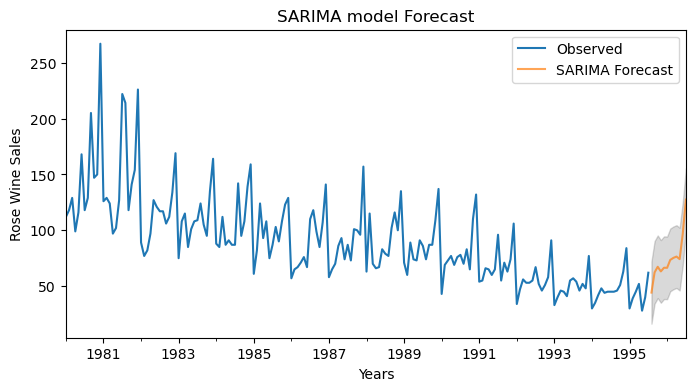

In [161]:
axis = rose_sales.plot(label='Observed', figsize=(8, 4))
sarima_final['forecast'].plot(ax=axis, label='SARIMA Forecast', alpha=0.7)
axis.fill_between(sarima_final.index, sarima_final['lower_ci_95'], sarima_final['upper_ci_95'], color='k', alpha=.15)
axis.set_xlabel('Years')
axis.set_ylabel('Rose Wine Sales')
plt.legend(loc='best')
plt.title('SARIMA model Forecast')
plt.show()

### Holt-Winters Model

In [162]:
hw_forecast = hw_alpha_model.forecast(steps=12)

In [163]:
idx = pd.date_range(start='1995-08-01',end='1996-07-01',freq='MS')
idx

DatetimeIndex(['1995-08-01', '1995-09-01', '1995-10-01', '1995-11-01',
               '1995-12-01', '1996-01-01', '1996-02-01', '1996-03-01',
               '1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01'],
              dtype='datetime64[ns]', freq='MS')

In [164]:
hw_prediction_df=pd.DataFrame(np.column_stack([hw_forecast]),columns=['Rose forecast'],index=idx)

In [165]:
hw_prediction_df

Rose forecast
1995-08-01      63.250304
1995-09-01      66.502226
1995-10-01      72.745883
1995-11-01      61.294074
1995-12-01      70.171620
1996-01-01      72.816548
1996-02-01      84.582624
1996-03-01      87.039507
1996-04-01      77.953628
1996-05-01      72.109303
1996-06-01      83.809185
1996-07-01     118.066326

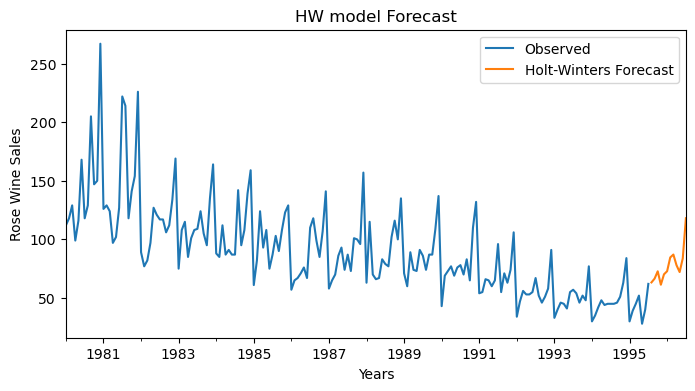

In [166]:
axis = rose_sales.plot(label='Observed', figsize=(8, 4))
hw_prediction_df['Rose forecast'].plot(ax=axis, label='Holt-Winters Forecast')
axis.set_xlabel('Years')
axis.set_ylabel('Rose Wine Sales')
plt.legend(loc='best')
plt.title('HW model Forecast')
plt.show()

## Comment on the model thus built and report your findings and suggest the measures that the company should be taking for future sales.

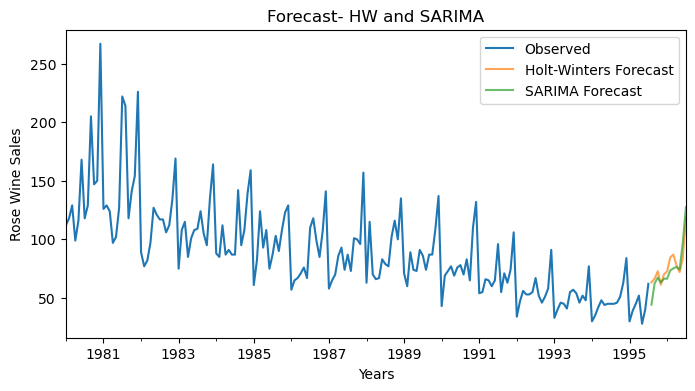

In [167]:
axis = rose_sales.plot(label='Observed', figsize=(8, 4))
hw_prediction_df['Rose forecast'].plot(ax=axis, label='Holt-Winters Forecast',alpha=0.7)
sarima_final['forecast'].plot(ax=axis, label='SARIMA Forecast', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Rose Wine Sales')
plt.legend(loc='best')
plt.title('Forecast- HW and SARIMA')
plt.show()

Observations:
- The wine sales peaks during the months of November and december, probably due to the holiday season. 
- The sales data exhibits declining trend

Insights:
- The seasonality component of sales can be capitalized, and can try to push sales in the peak months
- The trend component needs immediate addressing. The reasons for the declining trend need to be investigated and the sales has to be improved.